# **CSC461 Machine Learning Project**
## **Bike Sharing Analysis and Prediction**

*Hiba Akbi | Zina Kamel*
*SPRING 2024*

A project report as fullfillment of the requirements of the CSC461 Course


---



# **Problem Statement**

Throughout the project, we wish to explore the following two research questions:

*How accurately can we predict the duration level of a future trip from one of our customers?*

*How accurately can we predict the number of trips on a specific day and within a certain station?*


As a bike rental company, we noticed that our customers are frequently complaining about the high prices of the rentals when they take them on a longer trip. After assessing the problem internally, our business team suggested that we price longer trips at a less rate per hour than shorter ones. This would be easy to do if we only display the price at the end of the trip as we would identify if the trip was a short or long one. However, one of our added values is displaying the price to our customers before they start the trip. Hence, we wish to predict the duration level of an upcoming trip to display it to the user before confirming the booking.

On the other side, our sales team is interested in better understanding what factors influence customer’s daily usage of the bikes. For example, do weather conditions affect the number of trips taken in a day? By predicting the number of trips expected based on input data, the sales team will be more accurate in predicting profit,be able to set revenue targets, and take data driven decisions based on expected performance versus recorded one.

# Dataset Description

Our dataset is made up of 3 CSV files. The first file is called “trips.csv” and it has data about the bike trips we had. The second file is “station.csv” and it contains information about the different stations we have across the San Francisco Bay Area. Lastly, the “weather.csv” has information about the weather of the various days on which the trips were taken.

Each of these CSV files has informative features about the possible duration of the trip and they will be analyzed separately in the following sections. Afterward, we will combine them together to form the final dataset we will use for prediction.


*Note: The dataset we are using have been collected from Kaggle:* https://www.kaggle.com/datasets/benhamner/sf-bay-area-bike-share?select=trip.csv

# Data Loading

In [ ]:
!pip install kaggle

In [ ]:
import os
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Next step is uploading the kaggle.json file on colab.

In [ ]:
from google.colab import files

uploaded = files.upload()
!mv kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!cd /content/

In [ ]:
!kaggle datasets download -d benhamner/sf-bay-area-bike-share

sf-bay-area-bike-share.zip: Skipping, found more recently modified local copy (use --force to force download)


Now let's unzip it

In [ ]:
!unzip /content/sf-bay-area-bike-share.zip

Archive:  /content/sf-bay-area-bike-share.zip
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Exploration

Our dataset consists of several spreadsheets providing different information about the bikes.
We start by analysing every sub-dataset alone and then formulate the research questions we wish to explore. Based on these questions we will join the sub-datasets together and proceed with the data analysis and model development.

## Dataset Presentation


In [ ]:
# importing necessary libraries

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Trips Sub-Dataset




The trips dataset contains data of all recorded trips within a certain timeframe, and the corresponding attributes of a trip.

In [ ]:
tripdf = pd.read_csv('/content/trip.csv')
tripdf.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [ ]:
tripdf.shape

(669959, 11)

The trips dataset has 669959 rows and 11 columns. Again, we go about outlining the different columns we have:

In [ ]:
print(tripdf.columns)
print(tripdf.dtypes)

Index(['id', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_date', 'end_station_name', 'end_station_id',
       'bike_id', 'subscription_type', 'zip_code'],
      dtype='object')
id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object


* **id:** is the ID of the trip

* **duration:** is the duration of the bike trip in seconds

* **start_date, start_station_name, start_station_id:** Represent information about the departure, including the day, as well as the id and name of the station of departure.

* **end_date, end_station_name, end_station_id:** Represent information about the destination, including the date of arrival, as well as the id and name of the station of destination.

* **bike_id** is the ID of the bike used for the trip.

* **subscription_type** represents the type of subscription of the biker

* **zip_code** is the zipcode of the area of the start station of the trip.

Let us start by checking for null values.

In [ ]:
null_values_tripdf = tripdf.isnull()
null_counts_tripdf = null_values_tripdf.sum()

print("Number of null values in each column:")
print(null_counts_tripdf)

Number of null values in each column:
id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64


We note that the only column that includes null values is the Zip Code. We will handle these null values later if this column is of interest.

Next, let's explore the values of our remaining columns. We first get a summary of our categorical fields and see the range of their values, then move to the analysis of the numerical fields.

*   **Subscription type**

In [ ]:
tripdf['subscription_type'].unique()

array(['Subscriber', 'Customer'], dtype=object)

We have two types of subscription:

1.   **Customers:** Regular bikers that use our services.
2.   **Subscribers:** Consistent bikers that have enlisted a subscription to our company.

Let's explore how this variable is distributed across our trips.

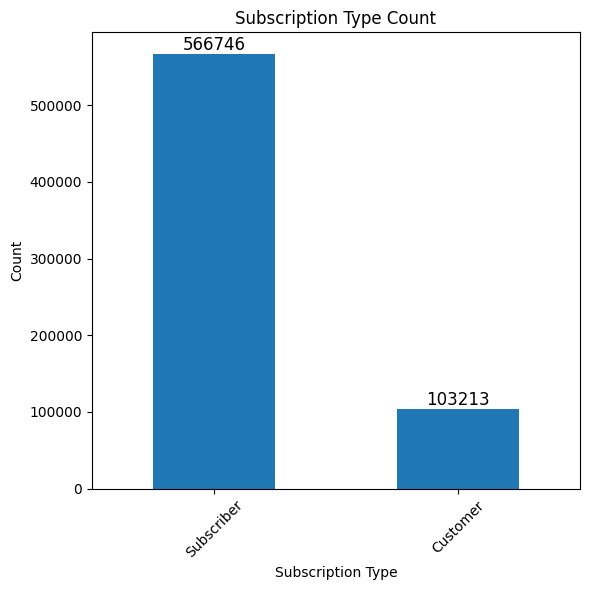

In [ ]:
subscription_type= tripdf['subscription_type'].value_counts()
plt.figure(figsize=(6, 6))
subscription_type.plot(kind='bar')
for i, v in enumerate(subscription_type):
    plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=12)
plt.title('Subscription Type Count')
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It seems that the overwhelming majority of the registered trips where taken by subscribers. We will need to be careful about this imbalance in the dataset when it comes to model building.

Now, let's look more closely into the timing and location of the trips to get insights on the most frequent iterinaries.



*   **Start and End stations**

We are first interested in checking the most used stations. Particularly, what are the most used stations for departure and what are the most common arrival stations.

Then, we look at the most used start station to determine what 5 destinations are most associated with it. In other words, we want to determine the 5 most likely destinations in our most used departure station.



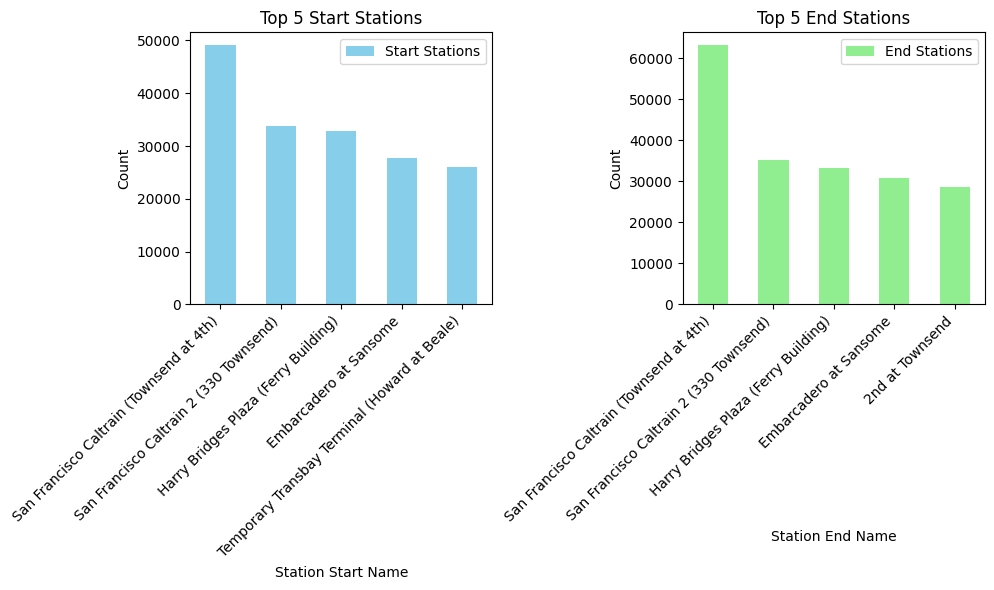

In [ ]:

start_stations = tripdf['start_station_name'].value_counts().nlargest(5)
end_stations = tripdf['end_station_name'].value_counts().nlargest(5)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
start_stations.plot(kind='bar', color='skyblue', label='Start Stations')
plt.title('Top 5 Start Stations')
plt.xlabel('Station Start Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.subplot(1, 2, 2)
end_stations.plot(kind='bar', color='lightgreen', label='End Stations')
plt.title('Top 5 End Stations')
plt.xlabel('Station End Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.legend()
plt.tight_layout()
plt.show()

As the graph shows, the 5 most frequent stations for both departures and arrivals are almost the same. With 'San Francisco Caltrain' being the most used for both departures and arrivals, followed by 'San Francisco Caltrain 2', 'Hary Bridges Plaza' and 'Embarcadero at Sansone'.

Finally, the least frequent stations out of the 5 are 'Transbay Terminal' for departures, and '2nd at Townsend' for arrivals.

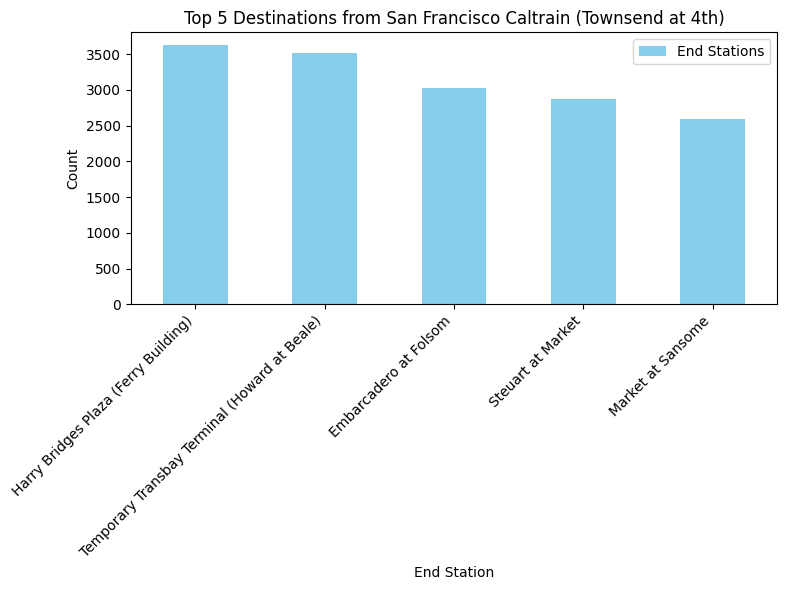

In [ ]:
most_used_start_station = tripdf['start_station_name'].value_counts().idxmax()
filtered_trips = tripdf[tripdf['start_station_name'] == most_used_start_station]

top_end_stations = filtered_trips['end_station_name'].value_counts().nlargest(5)

plt.figure(figsize=(8, 6))
top_end_stations.plot(kind='bar', color='skyblue', label='End Stations')
plt.title(f"Top 5 Destinations from {most_used_start_station}")
plt.xlabel('End Station')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


*   ****




*   **Days and Hours**

  After analyzing data pertaining to the location of the trips, we look at their distribution across days and hours.

  We start by parsing our column 'start_date' to the day, and the hour. We will keep each value in a new column, one called 'start_day' for the day, and 'start_time' for the timestamp. We do the same 'end_date', then proceed to plotting the values to get insights.


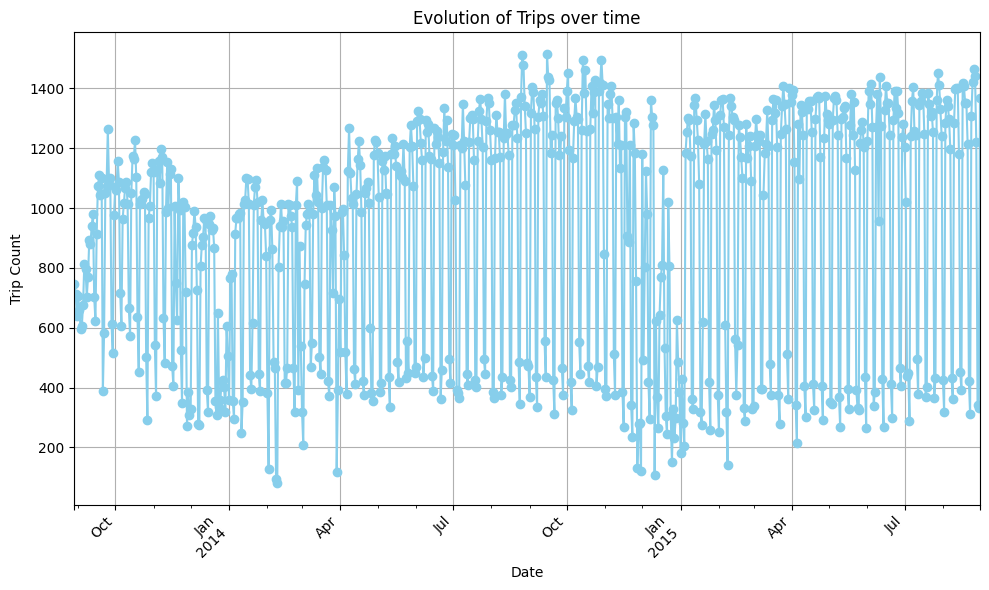

In [ ]:
#split the data into seperate columns
tripdf[['start_day', 'start_time']] = tripdf['start_date'].str.split(' ', expand=True)
tripdf['start_day'] = pd.to_datetime(tripdf['start_day'], format="%m/%d/%Y", errors='coerce')

trip_counts_by_date = tripdf.groupby('start_day').size()
plt.figure(figsize=(10, 6))
trip_counts_by_date.plot(kind='line', marker='o', color='skyblue', linestyle='-')
plt.title('Evolution of Trips over time')
plt.xlabel('Date')
plt.ylabel('Trip Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

The plot above shows the overall evolution of trips across days, months and years. The graph shows an evolution, with certain peaks and certain drops around specific months. However, it is difficult to get a good grasp of the meaning behind it.

We will then try to plot the trips evolution based on years, then months.

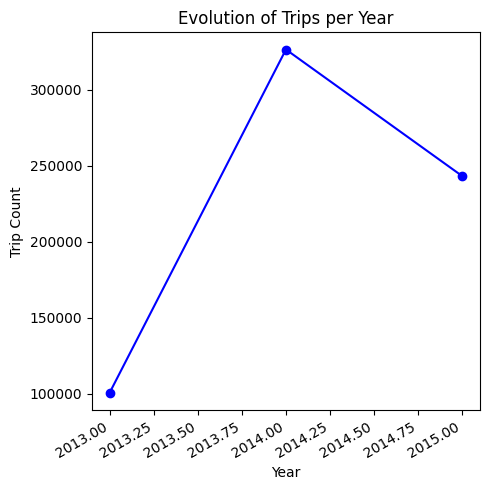

In [ ]:
tripdf['start_year'] = pd.to_datetime(tripdf['start_day'], format="%m-%d-%Y").dt.year
trip_counts_by_year = tripdf.groupby('start_year').size()

plt.figure(figsize=(5, 5))
trip_counts_by_year.plot(kind='line', marker='o', color='blue', linestyle='-')
plt.title('Evolution of Trips per Year')
plt.xlabel('Year')
plt.ylabel('Trip Count')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

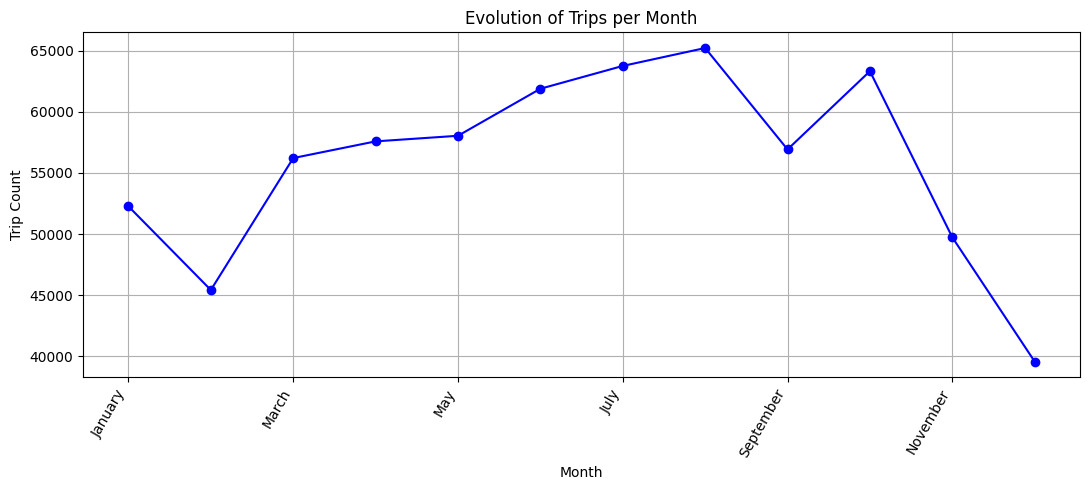

In [ ]:
tripdf['start_month'] = pd.to_datetime(tripdf['start_day'], format="%m-%d-%Y").dt.month_name()
trip_counts_by_month = tripdf.groupby('start_month').size()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

trip_counts_by_month = trip_counts_by_month.reindex(month_order)

plt.figure(figsize=(11, 5))
trip_counts_by_month.plot(kind='line', marker='o', color='blue', linestyle='-')
plt.title('Evolution of Trips per Month')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.xticks(rotation=60, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

From the graphed line charts, we can notice a clear peak in the year 2014, in comparison to the two other years.

On the other hand, the distribution across months show an interesting trend: spring and summer seem to have much more bike trips compared to winter and fall, with highest recorded trips in August, and lowest traffic in December.

This might suggets that the bike traffic is related to weather conditions, we keep this hypothesis in mind for our upcoming analysis on the weather dataset.


Now let us look at the evolution of trips across different times of the day. We look at hour newly created 'start_time', to establish the average trips per hour.

In [ ]:
tripdf['start_hour'] = pd.to_datetime(tripdf['start_time'], format='%H:%M').dt.hour
print(tripdf['start_hour'])

0         14
1         14
2         10
3         11
4         12
          ..
669954     4
669955     3
669956     0
669957     0
669958     0
Name: start_hour, Length: 669959, dtype: int32


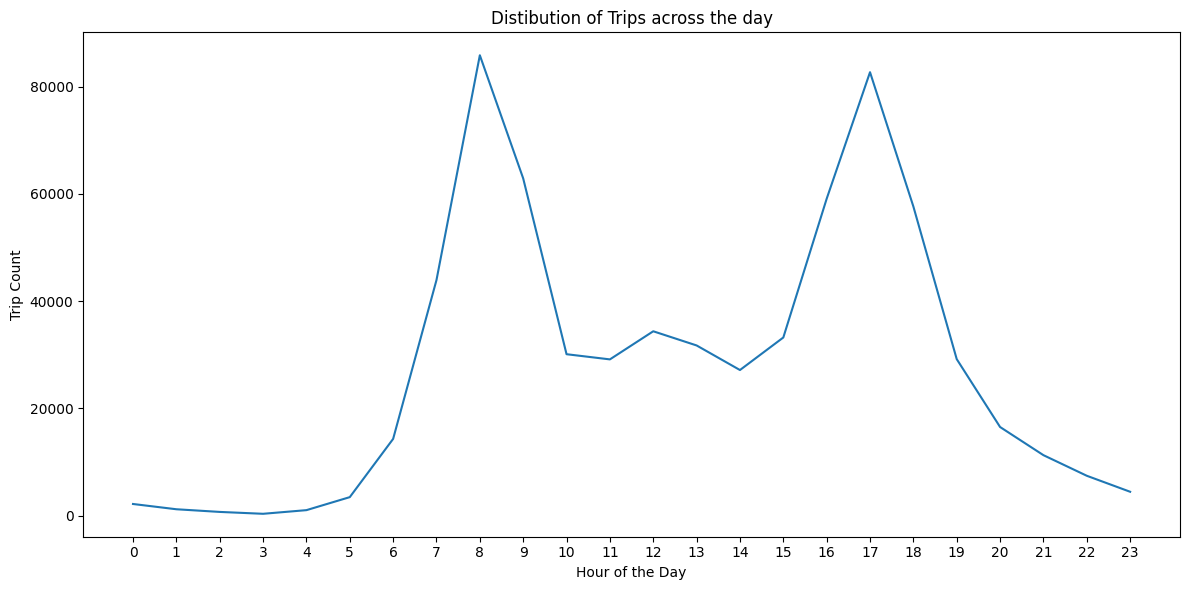

In [ ]:
hourly_avg = tripdf.groupby('start_hour').size()
hourly_avg.plot(kind='line', figsize=(12, 6))
plt.title('Distibution of Trips across the day')
plt.xlabel('Hour of the Day')
plt.ylabel('Trip Count')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

The graph above shows interesting insights of the hourly use of bikes. As can be seen, there are two peaks of uses within the day, one corresponding to 8 a.m, and the second to 5 p.m.

These two times correspond to the regular commute hours, where people go and come back from work/school.

Unsurprisingly, we have very few trips registered during the night (from 9p.m to 5 a.m), and an average amount during mid-day (11 a.m to 2 p.m).




*   **Duration**

The last step of our trips data analysis is to understand the variability in duration of our trips. First, we look at the values across our 'duration' column, they are in seconds, thus we convert them to minutes to make it easier to interpret.

In [ ]:
#convert secodns to minutes
tripdf['duration']= tripdf['duration']/60
print(tripdf['duration'].describe())

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64


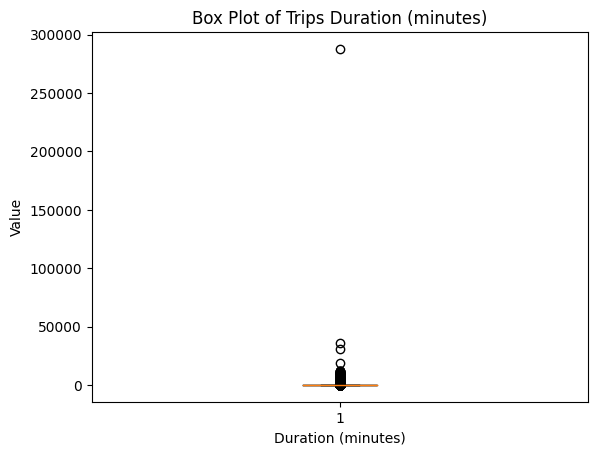

In [ ]:
plt.boxplot(tripdf['duration'])
plt.xlabel('Duration (minutes)')
plt.ylabel('Value')
plt.title('Box Plot of Trips Duration (minutes)')
plt.show()

As shown in the box plot, we have multiple outliers and a very high standard deviation, hinting at high variability and dispersion in our duration values.

From our 5 value summary, we see that Q1 is at around 5.7 min, Q2 at 8.6 min and Q3 at 12.5 min. However, by looking at our max values, we have registered abnormaly high durations for a bike trip.

Let's investigate that more.

We will start by determing how many outliers we have. We consider our threshold to be a trip longer than a day, i.e a duration > 24 hours.

In [ ]:
outlier = tripdf[tripdf['duration'] > 24*60]

selected_columns = ['duration', 'start_date', 'end_date']
print(outlier[selected_columns])

percentage =len(outlier['duration'])*100/ len(tripdf)
print(f"Percentage of trips with duration greater than a full day: % {percentage:.2f}" )

           duration       start_date         end_date
747     1628.550000  8/29/2013 13:30  8/30/2013 16:38
1461    4022.233333  8/30/2013 18:07   9/2/2013 13:10
2100    1562.733333  8/31/2013 16:26   9/1/2013 18:29
2101    2799.466667  8/31/2013 14:43   9/2/2013 13:22
2724    4198.833333   9/1/2013 18:43   9/4/2013 16:42
...             ...              ...              ...
654341  1496.483333  9/15/2014 19:16  9/16/2014 20:13
656921  4311.766667  9/12/2014 18:11  9/15/2014 18:03
657384  5412.916667  9/12/2014 13:46   9/16/2014 7:59
658455  4287.216667  9/11/2014 17:00  9/14/2014 16:27
662378  4245.000000   9/8/2014 18:05  9/11/2014 16:50

[296 rows x 3 columns]
Percentage of trips with duration greater than a full day: % 0.04


As shown above, we have around 300 entries with a bike ride taking longer than 24 hours long. Some of these entries being across multiple months, with start_dates in December and end-dates in June of the next year.

However these outliers only represent 0.04% . Additionally, as our research question is centered around daily trips, we are not interested in trips longer than that, so we drop these values.

In [ ]:
tripdf.drop(tripdf[tripdf['duration'] > 24*60].index, inplace=True)
print(tripdf['duration'].describe())

count    669663.000000
mean         16.455309
std          54.343746
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max        1439.683333
Name: duration, dtype: float64


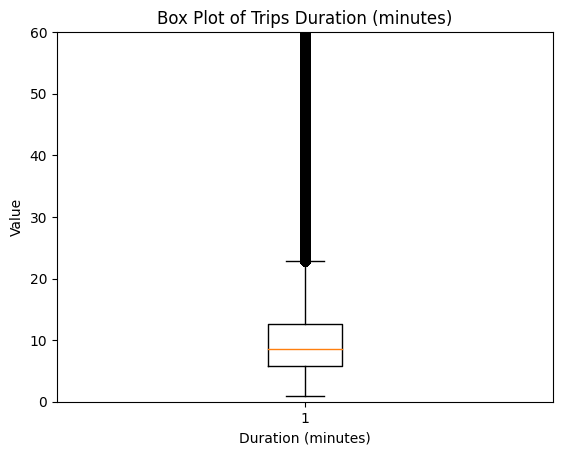

In [ ]:
plt.boxplot(tripdf['duration'])
plt.ylim(0, 60)
plt.xlabel('Duration (minutes)')
plt.ylabel('Value')
plt.title('Box Plot of Trips Duration (minutes)')
plt.show()

Our last step is to discard the 'end_date' column, since we are no longer interested in trips that lasted longer than a day.

In [ ]:
tripdf = tripdf.drop('end_date', axis=1)
tripdf

,id,duration,start_date,start_station_name,start_station_id,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_day,start_time,start_year,start_month,start_hour
0,4576,1.050000,8/29/2013 14:13,South Van Ness at Market,66,South Van Ness at Market,66,520,Subscriber,94127,2013-08-29,14:13,2013,August,14
1,4607,1.166667,8/29/2013 14:42,San Jose City Hall,10,San Jose City Hall,10,661,Subscriber,95138,2013-08-29,14:42,2013,August,14
2,4130,1.183333,8/29/2013 10:16,Mountain View City Hall,27,Mountain View City Hall,27,48,Subscriber,97214,2013-08-29,10:16,2013,August,10
3,4251,1.283333,8/29/2013 11:29,San Jose City Hall,10,San Jose City Hall,10,26,Subscriber,95060,2013-08-29,11:29,2013,August,11
4,4299,1.383333,8/29/2013 12:02,South Van Ness at Market,66,Market at 10th,67,319,Subscriber,94103,2013-08-29,12:02,2013,August,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669954,432951,10.316667,9/1/2014 4:21,Powell Street BART,39,Townsend at 7th,65,335,Subscriber,94118,2014-09-01,4:21,2014,September,4
669955,432950,111.866667,9/1/2014 3:16,Harry Bridges Plaza (Ferry Building),50,San Francisco Caltrain (Townsend at 4th),70,259,Customer,44100,2014-09-01,3:16,2014,September,3
669956,432949,8.966667,9/1/2014 0:05,South Van Ness at Market,66,5th at Howard,57,466,Customer,32,2014-09-01,0:05,2014,September,0
669957,432948,9.466667,9/1/2014 0:05,South Van Ness at Market,66,5th at Howard,57,461,Customer,32,2014-09-01,0:05,2014,September,0


Now let us move on to the next dataset: weather_dataset.

### Weather Sub-Dataset

The weather dataset contains data of the different weather information on a specific date for a specific location.

In [ ]:
weatherdf = pd.read_csv('/content/weather.csv')
weatherdf

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,8/27/2015,92.0,78.0,63.0,57.0,51.0,40.0,78.0,48.0,18.0,...,10.0,10.0,23.0,6.0,29.0,0,3.0,NaN,313.0,95113
3661,8/28/2015,95.0,80.0,64.0,64.0,56.0,52.0,93.0,60.0,26.0,...,10.0,10.0,25.0,7.0,30.0,0,3.0,NaN,307.0,95113
3662,8/29/2015,80.0,72.0,64.0,65.0,62.0,54.0,93.0,70.0,47.0,...,10.0,10.0,21.0,9.0,26.0,0,4.0,NaN,312.0,95113
3663,8/30/2015,78.0,70.0,62.0,60.0,57.0,53.0,84.0,64.0,43.0,...,10.0,10.0,22.0,10.0,29.0,0,3.0,NaN,291.0,95113


In [ ]:
print(weatherdf.shape)
weatherdf.columns

(3665, 24)


Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees', 'zip_code'],
      dtype='object')

Our weather dataset is made of 3665 rows, and 24 columns detailed as below:


*   **Date**: the specific day this data was recorded
*   **Max, mean, min temperature** Maximum, and minimum temperature recorded that day. And temperature for the day. Measure in Fahreienet.
*  **Max, mean, min humidity:** Maximum, and minimum humidity levels recorded that day. And average humidity for the day.
* **Max, mean, min dew point:** Maximum, and minimum dew point (temperature at which dew forms) recorded that day.
* **Max, min wind speed mph:** Maximum, and minimum win speed recorded that day in mph.
* **Win dir degerees**: Direction of the wind.
* **Cloud cover**: Indicates whether coverage of the sky in oktas.
* **Zip code**: Zip code of the location this data was recorded.
* **Events**: Description of the weather overall: cloudy, sunny, rainy ...etc


In [ ]:
weatherdf.describe()

,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,cloud_cover,wind_dir_degrees,zip_code
count,3661.000000,3661.000000,3661.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3611.000000,3664.000000,...,3664.000000,3652.000000,3652.000000,3652.000000,3664.000000,3664.000000,2766.000000,3664.000000,3664.000000,3665.000000
mean,70.580989,61.348812,51.947282,53.149820,48.794794,44.306840,85.446968,67.256993,46.458045,30.074997,...,29.965835,10.555312,9.822015,8.229737,16.398472,5.962063,22.299349,2.784389,266.605895,94325.000000
std,8.385572,7.234397,7.441444,6.885449,7.822281,9.355432,9.226972,10.945591,14.434784,0.134492,...,0.133476,2.193828,1.469894,2.862132,7.787588,3.340603,9.618813,2.276401,102.047645,404.615212
min,44.000000,38.000000,25.000000,20.000000,13.000000,2.000000,24.000000,24.000000,4.000000,29.500000,...,28.980000,5.000000,4.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,94041.000000
25%,64.000000,56.000000,47.000000,49.000000,44.000000,39.000000,82.000000,62.000000,37.000000,29.980000,...,29.880000,10.000000,10.000000,7.000000,13.000000,3.000000,17.000000,1.000000,254.000000,94063.000000
50%,70.000000,61.000000,53.000000,54.000000,49.000000,46.000000,86.000000,68.000000,48.000000,30.060000,...,29.950000,10.000000,10.000000,10.000000,16.000000,6.000000,22.000000,3.000000,297.000000,94107.000000
75%,77.000000,67.000000,58.000000,58.000000,55.000000,52.000000,93.000000,74.000000,56.000000,30.170000,...,30.050000,10.000000,10.000000,10.000000,20.000000,8.000000,25.000000,5.000000,330.000000,94301.000000
max,102.000000,84.000000,75.000000,68.000000,65.000000,63.000000,100.000000,96.000000,93.000000,30.650000,...,30.370000,20.000000,20.000000,20.000000,128.000000,23.000000,114.000000,8.000000,2772.000000,95113.000000


Let us convert the date column to the standard format of pandas. This will help us when joining the sub-datasets together.

In [ ]:
weatherdf['date'] = pd.to_datetime(weatherdf['date'], format='%m/%d/%Y', errors='coerce')

In [ ]:
weatherdf.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


Our next step is checking for null values.

In [ ]:
null_values_weatherdf = weatherdf.isnull()

null_counts_weatherdf = null_values_weatherdf.sum()

null_columns_weatherdf = null_values_weatherdf.any()

print("Number of null values in each column:")
print(null_counts_weatherdf)

print("\nColumns with null values:")
print(null_columns_weatherdf)

Number of null values in each column:
date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

Columns with

In [ ]:
weatherdf['zip_code'].value_counts()

zip_code
94107    733
94063    733
94301    733
94041    733
95113    733
Name: count, dtype: int64

We notice that we have multiple null values across different columns. Starting with the events column, we have 3143 null rows out of 3665. Our best option is to drop this column as we don't have enough filled rows to accurately handle these null values using methods such as mean or predictions. We do the same for gust wind speed which has 25% missing values.

In [ ]:
weatherdf.drop(columns=['events', 'max_gust_speed_mph'], inplace=True)
print(weatherdf.head())

        date  max_temperature_f  mean_temperature_f  min_temperature_f  \
0 2013-08-29               74.0                68.0               61.0   
1 2013-08-30               78.0                69.0               60.0   
2 2013-08-31               71.0                64.0               57.0   
3 2013-09-01               74.0                66.0               58.0   
4 2013-09-02               75.0                69.0               62.0   

   max_dew_point_f  mean_dew_point_f  min_dew_point_f  max_humidity  \
0             61.0              58.0             56.0          93.0   
1             61.0              58.0             56.0          90.0   
2             57.0              56.0             54.0          93.0   
3             60.0              56.0             53.0          87.0   
4             61.0              60.0             58.0          93.0   

   mean_humidity  min_humidity  ...  min_sea_level_pressure_inches  \
0           75.0          57.0  ...                       

Moving on to the next missing values, let's check the distribution of these nulls across the rows.

In [ ]:
null_rows = weatherdf[weatherdf.isnull().any(axis=1)]
print(null_rows)

           date  max_temperature_f  mean_temperature_f  min_temperature_f  \
1292 2014-03-05               71.0                63.0               55.0   
1305 2014-03-18               73.0                60.0               46.0   
1349 2014-05-01               87.0                72.0               57.0   
1350 2014-05-02               78.0                66.0               53.0   
1359 2014-05-11               78.0                64.0               51.0   
...         ...                ...                 ...                ...   
2911 2015-08-08                NaN                 NaN                NaN   
2915 2015-08-12               82.0                68.0               55.0   
3177 2015-05-01                NaN                 NaN                NaN   
3178 2015-05-02                NaN                 NaN                NaN   
3179 2015-05-03                NaN                 NaN                NaN   

      max_dew_point_f  mean_dew_point_f  min_dew_point_f  max_humidity  \
1

In [ ]:
null_values_weatherdf = weatherdf.isnull()

null_counts_weatherdf = null_values_weatherdf.sum()

null_columns_weatherdf = null_values_weatherdf.any()

print("Number of null values in each column:")
print(null_counts_weatherdf)

print("\nColumns with null values:")
print(null_columns_weatherdf)

Number of null values in each column:
date                               0
max_temperature_f                  4
mean_temperature_f                 4
min_temperature_f                  4
max_dew_point_f                   54
mean_dew_point_f                  54
min_dew_point_f                   54
max_humidity                      54
mean_humidity                     54
min_humidity                      54
max_sea_level_pressure_inches      1
mean_sea_level_pressure_inches     1
min_sea_level_pressure_inches      1
max_visibility_miles              13
mean_visibility_miles             13
min_visibility_miles              13
max_wind_Speed_mph                 1
mean_wind_speed_mph                1
precipitation_inches               1
cloud_cover                        1
wind_dir_degrees                   1
zip_code                           0
dtype: int64

Columns with null values:
date                              False
max_temperature_f                  True
mean_temperature_f          

After deleting both our columns, we have 66 remaining columns, mainly with 54 missing values across dew point and humidity, and 13 other missing values in visibility .

These values represent only 2% of our dataset, thus we will drop them.

In [ ]:
weatherdf.dropna(inplace=True)

#verify values after droping
null_values_weatherdf = weatherdf.isnull()

null_counts_weatherdf = null_values_weatherdf.sum()

null_columns_weatherdf = null_values_weatherdf.any()

print("Number of null values in each column:")
print(null_counts_weatherdf)

print("\nColumns with null values:")
print(null_columns_weatherdf)

Number of null values in each column:
date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
zip_code                          0
dtype: int64

Columns with null values:
date                              False
max_temperature_f                 False
mean_temperature_f                False
min_temper

Finally, we look at our variable types to convert any incorrect types.

In [ ]:
weatherdf.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
precipitation_inches                      object
cloud_cover                              float64
wind_dir_degrees    

Notice how 'precipitation_inches' was listed as 'object', although it is meant to represent inches. Let's look more closely into that.

In [ ]:
weatherdf['precipitation_inches'].unique()

array(['0', '0.23', 'T', '0.01', '0.28', '0.63', '0.29', '0.06', '0.85',
       '0.09', '0.64', '0.42', '0.35', '0.43', '0.22', '0.74', '0.03',
       '0.12', '0.16', '0.49', '0.17', '0.08', '0.04', '0.53', '0.07',
       '0.02', '0.83', '1.06', '1.71', '0.37', '0.27', '0.45', '0.78',
       '0.88', '0.66', '0.47', '0.1', '0.61', '0.14', '0.05', '0.68',
       '0.97', '0.26', '0.15', '0.87', '0.57', '0.69', '0.32', '0.21',
       '0.24', '0.52', '0.36', '0.33', '0.25', '0.11', '0.2', '1.18',
       '1.43', '3.12', '0.48', '0.19', '1.09', '0.65', '0.13', '0.91',
       '0.99', '0.18', '0.4', '1.07', '0.41', '0.34', '1.25', '1.85',
       '3.36', '0.71', '1.3', '0.72', '0.6', '0.51', '1.2', '1.28',
       '3.23', '0.55', '1.26', '0.39'], dtype=object)

Notice how we have different float values, except for a T value. Let's look at the occurence of this T value to determine if it is an incorrect entry or a meaningful value.


In [ ]:
count_T = weatherdf['precipitation_inches'].value_counts()['T']
print("Occurences of T as a precipitation value:",count_T,'out of: ', len(weatherdf))
print("Percentage of T as a precipitation value: %",count_T*100/len(weatherdf))

Occurences of T as a precipitation value: 143 out of:  3599
Percentage of T as a precipitation value: % 3.973325923867741


In this context, T value represents a 'trace'. Which means the precipitation was less than 0.01, but not 0. Since we would not want to drop 130 other rows, we will replace this value by 0.005.

Our data should have 'precipitation inches' as a float now.

In [ ]:
weatherdf['precipitation_inches'] = pd.to_numeric(weatherdf['precipitation_inches'].replace('T', 0.005), errors='coerce')
weatherdf.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
precipitation_inches                     float64
cloud_cover                              float64
wind_dir_degrees    

In [ ]:
weatherdf['precipitation_inches'].unique()

array([0.   , 0.23 , 0.005, 0.01 , 0.28 , 0.63 , 0.29 , 0.06 , 0.85 ,
       0.09 , 0.64 , 0.42 , 0.35 , 0.43 , 0.22 , 0.74 , 0.03 , 0.12 ,
       0.16 , 0.49 , 0.17 , 0.08 , 0.04 , 0.53 , 0.07 , 0.02 , 0.83 ,
       1.06 , 1.71 , 0.37 , 0.27 , 0.45 , 0.78 , 0.88 , 0.66 , 0.47 ,
       0.1  , 0.61 , 0.14 , 0.05 , 0.68 , 0.97 , 0.26 , 0.15 , 0.87 ,
       0.57 , 0.69 , 0.32 , 0.21 , 0.24 , 0.52 , 0.36 , 0.33 , 0.25 ,
       0.11 , 0.2  , 1.18 , 1.43 , 3.12 , 0.48 , 0.19 , 1.09 , 0.65 ,
       0.13 , 0.91 , 0.99 , 0.18 , 0.4  , 1.07 , 0.41 , 0.34 , 1.25 ,
       1.85 , 3.36 , 0.71 , 1.3  , 0.72 , 0.6  , 0.51 , 1.2  , 1.28 ,
       3.23 , 0.55 , 1.26 , 0.39 ])

In [ ]:
weatherdf.describe()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code
count,3599,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,...,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000,3599.000000
mean,2014-08-28 15:33:03.550986496,70.615727,61.360378,51.935816,53.151431,48.802723,44.321200,85.491525,67.337872,46.529036,...,29.965435,10.533204,9.833565,8.266185,16.419283,5.941095,0.020688,2.768269,267.405946,94325.656849
min,2013-08-29 00:00:00,44.000000,38.000000,25.000000,20.000000,13.000000,2.000000,24.000000,24.000000,4.000000,...,28.980000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94041.000000
25%,2014-02-24 12:00:00,64.000000,56.000000,47.000000,49.000000,44.000000,39.000000,82.000000,62.000000,37.000000,...,29.880000,10.000000,10.000000,7.000000,13.000000,3.000000,0.000000,1.000000,256.000000,94063.000000
50%,2014-08-26 00:00:00,70.000000,61.000000,53.000000,54.000000,49.000000,46.000000,86.000000,68.000000,48.000000,...,29.950000,10.000000,10.000000,10.000000,16.000000,6.000000,0.000000,3.000000,297.000000,94107.000000
75%,2015-03-03 00:00:00,77.000000,67.000000,58.000000,58.000000,55.000000,52.000000,93.000000,74.000000,56.000000,...,30.050000,10.000000,10.000000,10.000000,20.000000,8.000000,0.000000,5.000000,330.000000,94301.000000
max,2015-08-31 00:00:00,102.000000,84.000000,73.000000,68.000000,65.000000,63.000000,100.000000,96.000000,93.000000,...,30.370000,20.000000,20.000000,20.000000,128.000000,23.000000,3.360000,8.000000,2772.000000,95113.000000
std,NaN,8.367822,7.243705,7.452540,6.879259,7.822054,9.358981,9.166660,10.854528,14.398180,...,0.132795,2.150002,1.454260,2.836424,7.719159,3.333906,0.142889,2.262679,101.398333,408.214139


### Stations Sub-Dataset



The stations dataset contains data of the different stations where users can pickup or return bikes.

In [ ]:
stationdf = pd.read_csv('/content/station.csv')
stationdf.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
stationdf.shape

(70, 7)

The stations dataset has 70 rows and 7 columns. Next step is outlining the different columns we have.

In [ ]:
stationdf.columns

Index(['id', 'name', 'lat', 'long', 'dock_count', 'city', 'installation_date'], dtype='object')

**id:** unique ID for each station

**name:** Station name

**lat:** latitude

**long:** longitude

**dock_count:** number of bikes the station can hold

**city:** the city of the station

**installation_date:** the date at which the station was started

We start by analyzing the null count of the stations dataframe.

In [ ]:
null_values_stationdf = stationdf.isnull()

null_counts_stationdf = null_values_stationdf.sum()

null_columns_stationdf = null_values_stationdf.any()

print("Number of null values in each column:")
print(null_counts_stationdf)

print("\nColumns with null values:")
print(null_columns_stationdf)

Number of null values in each column:
id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

Columns with null values:
id                   False
name                 False
lat                  False
long                 False
dock_count           False
city                 False
installation_date    False
dtype: bool


We do not have any null values so we can proceed with the data analysis.

In [ ]:
stationdf.describe()

,id,lat,long,dock_count
count,70.000000,70.000000,70.000000,70.000000
mean,43.000000,37.590243,-122.218416,17.657143
std,24.166092,0.203473,0.209446,4.010442
min,2.000000,37.329732,-122.418954,11.000000
25%,24.250000,37.389483,-122.400601,15.000000
50%,43.500000,37.631163,-122.312123,15.000000
75%,63.750000,37.788123,-122.078009,19.000000
max,84.000000,37.804770,-121.877349,27.000000


The ID of the station will be useful to us when we join the different spreadsheets later on but for now let's visualize the remaining variables

In [ ]:
stationdf['city'].unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

In [ ]:
city_counts = stationdf['city'].value_counts()
print(city_counts)

city
San Francisco    35
San Jose         16
Redwood City      7
Mountain View     7
Palo Alto         5
Name: count, dtype: int64


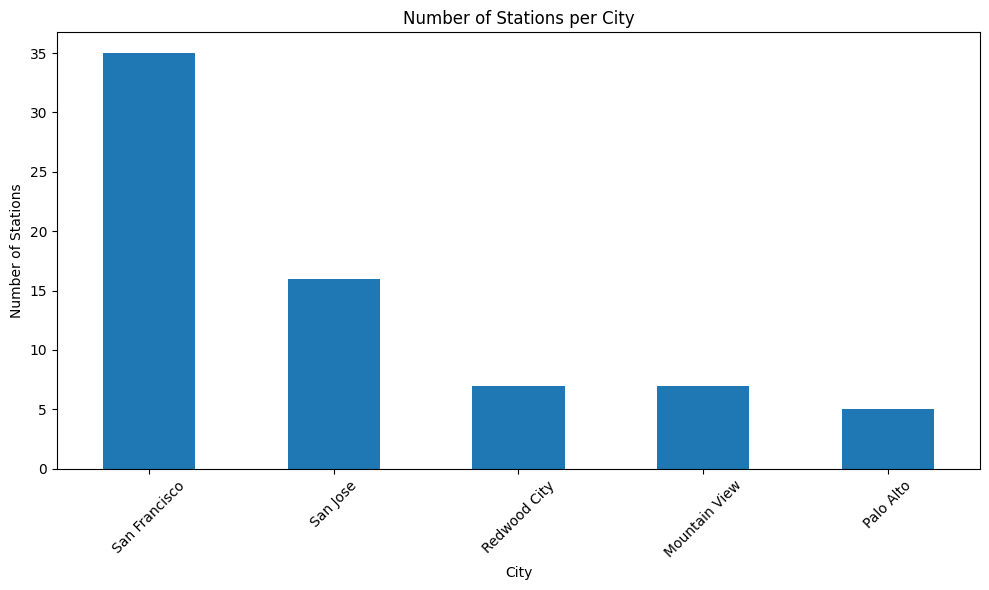

In [ ]:
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar')
plt.title('Number of Stations per City')
plt.xlabel('City')
plt.ylabel('Number of Stations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The San Francisco station has the highest number of stations among the cities (35 stations), which might indicate the highest demand.

In [ ]:
stationdf['installation_date'].value_counts()

installation_date
8/23/2013     7
8/19/2013     6
8/20/2013     6
8/5/2013      5
8/22/2013     5
8/21/2013     5
8/25/2013     5
8/6/2013      5
8/15/2013     5
8/14/2013     4
8/12/2013     4
8/7/2013      4
12/31/2013    3
8/16/2013     3
1/22/2014     1
2/20/2014     1
4/9/2014      1
Name: count, dtype: int64

The stations were installed between 23 August, 2013 and 9 April, 2014 with several stations being installed on the same date.

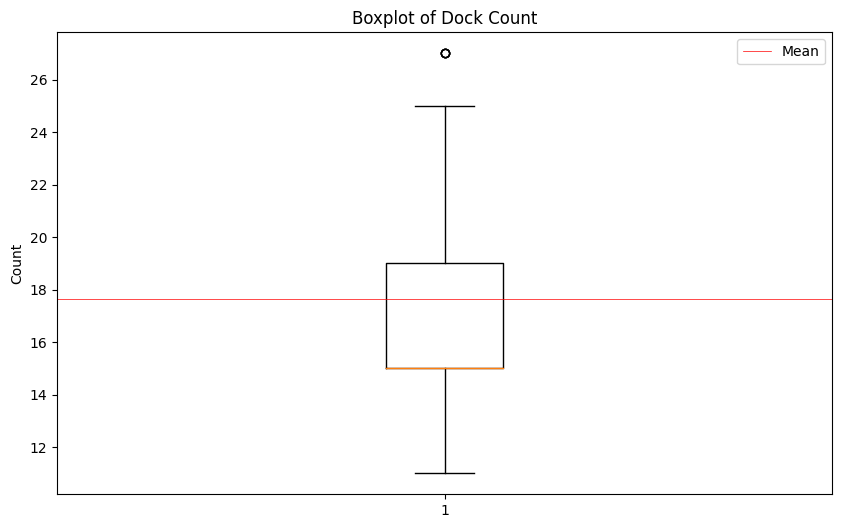

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(stationdf['dock_count'])

mean_dockcount = np.mean(stationdf['dock_count'])

plt.axhline(y=mean_dockcount, color='r', linestyle='-', linewidth=0.5, label='Mean')

plt.title('Boxplot of Dock Count')
plt.ylabel('Count')
plt.legend()
plt.show()

The mean number of the bikes a station can hold is 17 with an outlier value of 27. The presence of this outlier might affect our standardization or model performance in the upcoming stages, so let us process it.

In [ ]:
stationdf[stationdf['dock_count'] == 27]

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
49,61,2nd at Townsend,37.780526,-122.390288,27,San Francisco,8/22/2013
55,67,Market at 10th,37.776619,-122.417385,27,San Francisco,8/23/2013
65,77,Market at Sansome,37.789625,-122.400811,27,San Francisco,8/25/2013


There are four stations that have the dock count outlier of 27. We are going to drop these rows as they are few in number.

In [ ]:
stationdf.drop(stationdf[stationdf['dock_count']==27].index, inplace=True)

In [ ]:
stationdf[stationdf['dock_count'] == 27]

,id,name,lat,long,dock_count,city,installation_date


In [ ]:
stationdf

,id,name,lat,long,dock_count,city,installation_date
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013
...,...,...,...,...,...,...,...
64,76,Market at 4th,37.786305,-122.404966,19,San Francisco,8/25/2013
66,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013
67,82,Broadway St at Battery St,37.798541,-122.400862,15,San Francisco,1/22/2014
68,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014


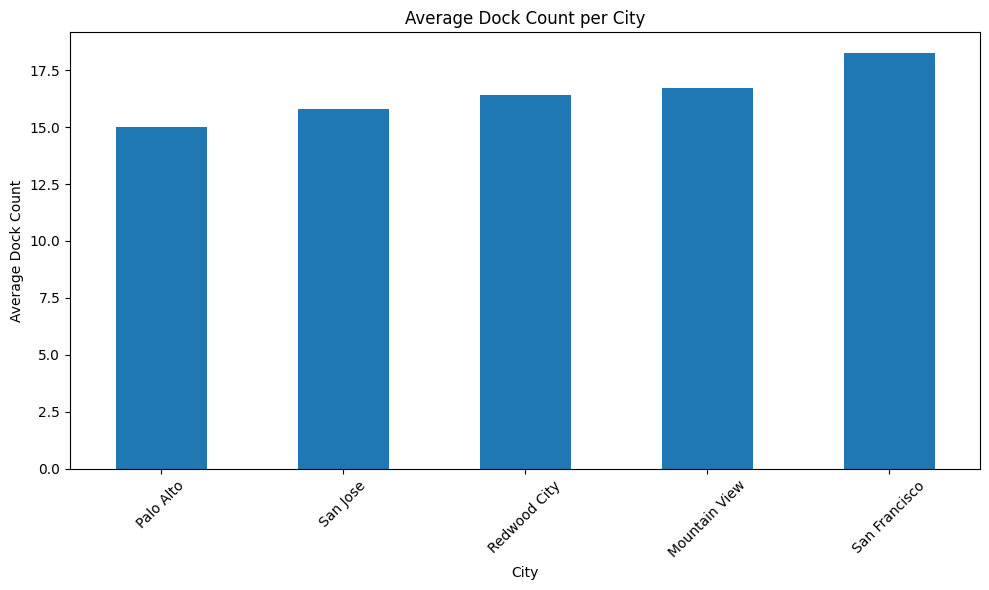

In [ ]:
average_dock_count = stationdf.groupby('city')['dock_count'].mean().sort_values()

plt.figure(figsize=(10, 6))
average_dock_count.plot(kind='bar')
plt.title('Average Dock Count per City')
plt.xlabel('City')
plt.ylabel('Average Dock Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

San Francisco has the highest number of average bikes per station, which is expected given the high demand identified earlier for this city

In [ ]:
import folium
from folium.plugins import MarkerCluster

map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=11)

marker_cluster = MarkerCluster().add_to(map_sf)

for index, row in stationdf.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=row['name'],
        icon=None
    ).add_to(marker_cluster)

map_sf


Using this interactive map, we can see the distribution of the multiple stations across the different cities. As expected, San Francisco has the highest number of stations (35).

Within every location, the stations are scattered at different places to cover multiple points of demand in the city.

This map can be useful to collectively visualize the locations of the stations when deciding on the next place to expand to.

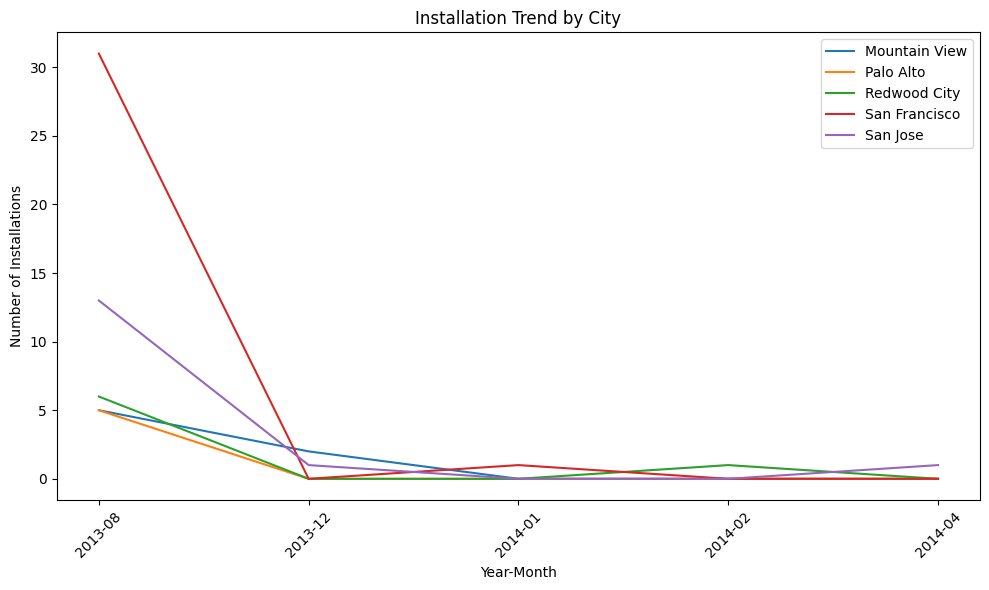

In [ ]:
stationdf['installation_date'] = pd.to_datetime(stationdf['installation_date'])

stationdf['year_month'] = stationdf['installation_date'].dt.to_period('M')

installation_trend = stationdf.groupby(['year_month', 'city']).size().unstack(fill_value=0)

installation_trend.index = installation_trend.index.strftime('%Y-%m')

plt.figure(figsize=(10, 6))
for city in installation_trend.columns:
    plt.plot(installation_trend.index, installation_trend[city], label=city)

plt.title('Installation Trend by City')
plt.xlabel('Year-Month')
plt.ylabel('Number of Installations')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can note that the business has started the installation at multiple locations as the same time, with San Francisco being the location where the most stations have been installed initially.
Moreover, following the initial installation there has been no additional large expansion in any location with the number of installations dropping to around 0.

# ***Research Question 1***
***How accurately can we predict the duration level of a future trip from one of our customers?***

# Data Joining

## **Joining Trips and Stations**


Next, we will join the trips and stations data set. Both will be joined on the common column they have 'start_station_id' and 'station_id'. We are interested in creating a table that includes the station details of the departure station of every trip.



The stations sub-dataset does not have a zip_code column but it has columns for longitude and latitude. Hence, we will extract the zip_code for every station from these columns.

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my_geocoder")

def get_zipcode(row):
    location = geolocator.reverse((row['lat'], row['long']))
    return location.raw['address'].get('postcode')

stationdf['zip_code'] = stationdf.apply(get_zipcode, axis=1)

print(stationdf)

    id                             name        lat        long  dock_count  \
1    3            San Jose Civic Center  37.330698 -121.888979          15   
2    4           Santa Clara at Almaden  37.333988 -121.894902          11   
3    5                 Adobe on Almaden  37.331415 -121.893200          19   
4    6                 San Pedro Square  37.336721 -121.894074          15   
5    7             Paseo de San Antonio  37.333798 -121.886943          15   
..  ..                              ...        ...         ...         ...   
64  76                    Market at 4th  37.786305 -122.404966          19   
66  80  Santa Clara County Civic Center  37.352601 -121.905733          15   
67  82        Broadway St at Battery St  37.798541 -122.400862          15   
68  83                       Mezes Park  37.491269 -122.236234          15   
69  84                      Ryland Park  37.342725 -121.895617          15   

             city installation_date year_month zip_code  
1    

In [ ]:
null_values_stationdf = stationdf.isnull()

null_counts_stationdf = null_values_stationdf.sum()

null_columns_stationdf = null_values_stationdf.any()

print("Number of null values in each column:")
print(null_counts_stationdf)

print("\nColumns with null values:")
print(null_columns_stationdf)

Number of null values in each column:
id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
year_month           0
zip_code             2
dtype: int64

Columns with null values:
id                   False
name                 False
lat                  False
long                 False
dock_count           False
city                 False
installation_date    False
year_month           False
zip_code              True
dtype: bool


We were able to successfully generate the zip_codes of the stations except for one row. Let's investigate it

In [ ]:
rows_with_null_zip_code = stationdf[stationdf['zip_code'].isnull()]
print(rows_with_null_zip_code)

    id                                 name        lat        long  \
8   10                   San Jose City Hall  37.337391 -121.886995   
63  75  Mechanics Plaza (Market at Battery)  37.791300 -122.399051   

    dock_count           city installation_date year_month zip_code  
8           15       San Jose        2013-08-06    2013-08     None  
63          19  San Francisco        2013-08-25    2013-08     None  


We were not able to generate the zip_codes for station 10 so we can drop these rows  

In [ ]:
# Drop rows with null values in the 'zip_code' column
stationdf = stationdf.dropna(subset=['zip_code'])
null_values_stationdf = stationdf.isnull()

null_counts_stationdf = null_values_stationdf.sum()

print("Number of null values in each column:")
print(null_counts_stationdf)

Number of null values in each column:
id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
year_month           0
zip_code             0
dtype: int64


Before proceeding , let's investigate the data types of the columns.

In [ ]:
stationdf.dtypes

id                            int64
name                         object
lat                         float64
long                        float64
dock_count                    int64
city                         object
installation_date    datetime64[ns]
year_month                period[M]
zip_code                     object
dtype: object

In [ ]:
stationdf['zip_code'].unique()

array(['95113', '95110', '95112', '95192', '94063', '94603', '94041',
       '94043', '94040', '94039', '94301', '94036', '94306', '94111',
       '94113', '94104', '94105', '94107', '94017', '94103', '94102',
       '90103', '94108', '94133'], dtype=object)

It looks like our zip code have all integer values, but they have been listed as objects because the columns previously had null values. We'll fix that now by converting to int.

In [ ]:
stationdf['zip_code'] = stationdf['zip_code'].astype('int64')
stationdf.dtypes

<ipython-input-210-f30357f4709c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationdf['zip_code'] = stationdf['zip_code'].astype('int64')


id                            int64
name                         object
lat                         float64
long                        float64
dock_count                    int64
city                         object
installation_date    datetime64[ns]
year_month                period[M]
zip_code                      int64
dtype: object

Now, we are finally ready to merge. Let's merge on start station id.

In [ ]:
tripjoineddf=tripdf.merge(stationdf, left_on='start_station_id', right_on='id')
tripjoineddf

,id_x,duration,start_date,start_station_name,start_station_id,end_station_name,end_station_id,bike_id,subscription_type,zip_code_x,...,start_hour,id_y,name,lat,long,dock_count,city,installation_date,year_month,zip_code_y
0,4576,1.050000,8/29/2013 14:13,South Van Ness at Market,66,South Van Ness at Market,66,520,Subscriber,94127,...,14,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
1,4299,1.383333,8/29/2013 12:02,South Van Ness at Market,66,Market at 10th,67,319,Subscriber,94103,...,12,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
2,4760,1.883333,8/29/2013 17:01,South Van Ness at Market,66,South Van Ness at Market,66,553,Subscriber,94103,...,17,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
3,5070,2.800000,8/29/2013 21:43,South Van Ness at Market,66,South Van Ness at Market,66,598,Subscriber,94115,...,21,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
4,4765,3.800000,8/29/2013 17:05,South Van Ness at Market,66,Market at 10th,67,553,Subscriber,94103,...,17,66,South Van Ness at Market,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575233,433758,7.650000,9/2/2014 8:17,Ryland Park,84,Santa Clara County Civic Center,80,233,Subscriber,95112,...,8,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112
575234,433727,6.816667,9/2/2014 8:09,Ryland Park,84,San Jose Civic Center,3,185,Subscriber,5112,...,8,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112
575235,433653,11.600000,9/2/2014 7:49,Ryland Park,84,San Jose Diridon Caltrain Station,2,122,Subscriber,95110,...,7,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112
575236,433552,10.933333,9/2/2014 7:12,Ryland Park,84,San Jose Diridon Caltrain Station,2,12,Subscriber,95110,...,7,84,Ryland Park,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112


In [ ]:
tripjoineddf.columns

Index(['id_x', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id', 'bike_id',
       'subscription_type', 'zip_code_x', 'start_day', 'start_time',
       'start_year', 'start_month', 'start_hour', 'id_y', 'name', 'lat',
       'long', 'dock_count', 'city', 'installation_date', 'year_month',
       'zip_code_y'],
      dtype='object')

We rename the columns for better readability, then get a summary of our data. We will also drop certain columns, including the original 'zip_code' column that we had in our trips dataset, since the station dataset has all needed values.

In [ ]:
tripjoineddf = tripjoineddf.rename(columns={'id_x': 'id_trip'})
tripjoineddf = tripjoineddf.rename(columns={'zip_code_y': 'zip_code'})
tripjoineddf = tripjoineddf.drop(['id_y', 'zip_code_x','name'], axis=1)
tripjoineddf

,id_trip,duration,start_date,start_station_name,start_station_id,end_station_name,end_station_id,bike_id,subscription_type,start_day,...,start_year,start_month,start_hour,lat,long,dock_count,city,installation_date,year_month,zip_code
0,4576,1.050000,8/29/2013 14:13,South Van Ness at Market,66,South Van Ness at Market,66,520,Subscriber,2013-08-29,...,2013,August,14,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
1,4299,1.383333,8/29/2013 12:02,South Van Ness at Market,66,Market at 10th,67,319,Subscriber,2013-08-29,...,2013,August,12,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
2,4760,1.883333,8/29/2013 17:01,South Van Ness at Market,66,South Van Ness at Market,66,553,Subscriber,2013-08-29,...,2013,August,17,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
3,5070,2.800000,8/29/2013 21:43,South Van Ness at Market,66,South Van Ness at Market,66,598,Subscriber,2013-08-29,...,2013,August,21,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
4,4765,3.800000,8/29/2013 17:05,South Van Ness at Market,66,Market at 10th,67,553,Subscriber,2013-08-29,...,2013,August,17,37.774814,-122.418954,19,San Francisco,2013-08-23,2013-08,94103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575233,433758,7.650000,9/2/2014 8:17,Ryland Park,84,Santa Clara County Civic Center,80,233,Subscriber,2014-09-02,...,2014,September,8,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112
575234,433727,6.816667,9/2/2014 8:09,Ryland Park,84,San Jose Civic Center,3,185,Subscriber,2014-09-02,...,2014,September,8,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112
575235,433653,11.600000,9/2/2014 7:49,Ryland Park,84,San Jose Diridon Caltrain Station,2,122,Subscriber,2014-09-02,...,2014,September,7,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112
575236,433552,10.933333,9/2/2014 7:12,Ryland Park,84,San Jose Diridon Caltrain Station,2,12,Subscriber,2014-09-02,...,2014,September,7,37.342725,-121.895617,15,San Jose,2014-04-09,2014-04,95112


In [ ]:
#verify values after droping
null_values_tripjoineddf = tripjoineddf.isnull()

null_counts_tripjoineddf = null_values_tripjoineddf.sum()

null_columns_tripjoineddf = null_values_tripjoineddf.any()

print("Number of null values in each column:")
print(null_counts_tripjoineddf)

print("\nColumns with null values:")
print(null_columns_tripjoineddf)

Number of null values in each column:
id_trip               0
duration              0
start_date            0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
bike_id               0
subscription_type     0
start_day             0
start_time            0
start_year            0
start_month           0
start_hour            0
lat                   0
long                  0
dock_count            0
city                  0
installation_date     0
year_month            0
zip_code              0
dtype: int64

Columns with null values:
id_trip               False
duration              False
start_date            False
start_station_name    False
start_station_id      False
end_station_name      False
end_station_id        False
bike_id               False
subscription_type     False
start_day             False
start_time            False
start_year            False
start_month           False
start_hour            False
lat                   Fals

## **Joining Trips+Stations and Weather**

Now that we have both trips and stations joined, we can join our dataframe with the weather data frame to get the weather conditions on every trip.
We will be joining both tables based on the common columns 'start_day' and 'zip_code'.

Since we are interested in matching trips and weather based on the date, let's ensure that we have the same date range across both tables first.

In [ ]:
start_date_trip = tripjoineddf['start_day'].min()
end_date_trip = tripjoineddf['start_day'].max()

start_date_weather = weatherdf['date'].min()
end_date_weather = weatherdf['date'].max()

print("Start Date Weather Dataset :", start_date_trip)
print("End Date Weather Dataset:", end_date_trip)

print("Start Date Trip Dataset:", start_date_trip)
print("End Date Trip Dataset:", end_date_trip)

Start Date Weather Dataset : 2013-08-29 00:00:00
End Date Weather Dataset: 2015-08-31 00:00:00
Start Date Trip Dataset: 2013-08-29 00:00:00
End Date Trip Dataset: 2015-08-31 00:00:00


Our timeline matches for both tables, that's our clue that our join table on 'date' will be sucessfull.

In [ ]:
tripfinaldf = pd.merge(left=tripjoineddf, right=weatherdf, left_on=['zip_code', 'start_day'], right_on=['zip_code', 'date'])
tripfinaldf

,id_trip,duration,start_date,start_station_name,start_station_id,end_station_name,end_station_id,bike_id,subscription_type,start_day,...,mean_sea_level_pressure_inches,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees
0,4130,1.183333,8/29/2013 10:16,Mountain View City Hall,27,Mountain View City Hall,27,48,Subscriber,2013-08-29,...,30.04,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0
1,4081,3.633333,8/29/2013 9:38,Mountain View City Hall,27,Mountain View City Hall,27,150,Subscriber,2013-08-29,...,30.04,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0
2,4084,4.783333,8/29/2013 9:41,Mountain View City Hall,27,Mountain View City Hall,27,138,Customer,2013-08-29,...,30.04,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0
3,4136,11.466667,8/29/2013 10:20,Mountain View City Hall,27,Mountain View City Hall,27,149,Customer,2013-08-29,...,30.04,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0
4,5091,17.683333,8/29/2013 22:11,Mountain View City Hall,27,Mountain View City Hall,27,56,Subscriber,2013-08-29,...,30.04,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,701900,498.083333,3/28/2015 9:03,Mezes Park,83,Mezes Park,83,121,Customer,2015-03-28,...,30.16,30.08,10.0,10.0,10.0,12.0,3.0,0.0,1.0,293.0
109375,676326,3.766667,3/10/2015 19:21,Mezes Park,83,Redwood City Caltrain Station,22,683,Subscriber,2015-03-10,...,29.97,29.94,10.0,8.0,1.0,14.0,2.0,0.0,6.0,296.0
109376,526834,3.850000,11/3/2014 11:50,Mezes Park,83,Redwood City Caltrain Station,22,78,Subscriber,2014-11-03,...,30.23,30.18,10.0,10.0,10.0,9.0,1.0,0.0,1.0,308.0
109377,526831,2.016667,11/3/2014 11:46,Mezes Park,83,Mezes Park,83,78,Subscriber,2014-11-03,...,30.23,30.18,10.0,10.0,10.0,9.0,1.0,0.0,1.0,308.0


In [ ]:
tripfinaldf.columns

Index(['id_trip', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id', 'bike_id',
       'subscription_type', 'start_day', 'start_time', 'start_year',
       'start_month', 'start_hour', 'lat', 'long', 'dock_count', 'city',
       'installation_date', 'year_month', 'zip_code', 'date',
       'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees'],
      dtype='object')

Again, we clean up redundant columns resulting from the join.

In [ ]:
#verify values after droping
tripfinaldf = tripfinaldf.drop('date', axis=1)
tripfinaldf.columns

Index(['id_trip', 'duration', 'start_date', 'start_station_name',
       'start_station_id', 'end_station_name', 'end_station_id', 'bike_id',
       'subscription_type', 'start_day', 'start_time', 'start_year',
       'start_month', 'start_hour', 'lat', 'long', 'dock_count', 'city',
       'installation_date', 'year_month', 'zip_code', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'precipitation_inches',
       'cloud_cover', 'wind_dir_degrees'],
      dtype='object')

Our merged data is finally ready, we proceed to cleaning up the columns that are redundant before proceeding to exploring correlations.

In [ ]:
tripfinaldf = tripfinaldf.drop(['lat','long','end_station_name','start_station_name','zip_code','year_month','start_day','start_time','start_year','start_month','start_hour'], axis=1)
print(tripfinaldf.columns)
print(tripfinaldf.dtypes)

Index(['id_trip', 'duration', 'start_date', 'start_station_id',
       'end_station_id', 'bike_id', 'subscription_type', 'dock_count', 'city',
       'installation_date', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees'],
      dtype='object')
id_trip                                    int64
duration                                 float64
start_date                                object
start_station_id                           int64
end_station_id                             int64
bike_id                                    int64
subscription_ty

# Data Preprocessing

**Duration Class**

We proceed to split the duration data into classes based on the values from our interquartile ranges as follows:


*   **Very short** <5 min
*   **Short** [5, 10] min
*   **Average** [10, 20] min
*   **Long** 20+ min


In [ ]:
bins = [0, 5, 10, 20, float('inf')]
labels = ['very short', 'short', 'average', 'long']

tripfinaldf['duration_class'] = pd.cut(tripfinaldf['duration'], bins=bins, labels=labels)
print(tripfinaldf['duration_class'].value_counts())

#drop duration
tripfinaldf = tripfinaldf.drop(['duration'], axis=1)
tripfinaldf.columns

duration_class
short         48066
average       26961
very short    23675
long          10677
Name: count, dtype: int64


Index(['id_trip', 'start_date', 'start_station_id', 'end_station_id',
       'bike_id', 'subscription_type', 'dock_count', 'city',
       'installation_date', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees', 'duration_class'],
      dtype='object')

Let us split our column 'start_date' of type object, into day, month, year, and hours integer columns.

**Data Type Conversion**

In [ ]:
tripfinaldf.head()

,id_trip,start_date,start_station_id,end_station_id,bike_id,subscription_type,dock_count,city,installation_date,max_temperature_f,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,duration_class
0,4130,8/29/2013 10:16,27,27,48,Subscriber,15,Mountain View,2013-08-16,80.0,...,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0,very short
1,4081,8/29/2013 9:38,27,27,150,Subscriber,15,Mountain View,2013-08-16,80.0,...,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0,very short
2,4084,8/29/2013 9:41,27,27,138,Customer,15,Mountain View,2013-08-16,80.0,...,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0,very short
3,4136,8/29/2013 10:20,27,27,149,Customer,15,Mountain View,2013-08-16,80.0,...,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0,average
4,5091,8/29/2013 22:11,27,27,56,Subscriber,15,Mountain View,2013-08-16,80.0,...,29.94,10.0,10.0,10.0,16.0,5.0,0.0,4.0,355.0,average


In [ ]:
format_str = '%m/%d/%Y %H:%M'
tripfinaldf['year'] = pd.to_datetime(tripfinaldf['start_date'], format=format_str).dt.year
tripfinaldf['month'] = pd.to_datetime(tripfinaldf['start_date'], format=format_str).dt.month
tripfinaldf['day'] = pd.to_datetime(tripfinaldf['start_date'], format=format_str).dt.day
tripfinaldf['hour'] = pd.to_datetime(tripfinaldf['start_date'], format=format_str).dt.hour

format_installation_str = '%m/%d/%Y'
tripfinaldf['installation_year'] = pd.to_datetime(tripfinaldf['installation_date'], format=format_installation_str).dt.year
tripfinaldf['installation_month'] = pd.to_datetime(tripfinaldf['installation_date'], format=format_installation_str).dt.month
tripfinaldf['installation_day'] = pd.to_datetime(tripfinaldf['installation_date'], format=format_installation_str).dt.day

print(tripfinaldf.dtypes)

id_trip                                    int64
start_date                                object
start_station_id                           int64
end_station_id                             int64
bike_id                                    int64
subscription_type                         object
dock_count                                 int64
city                                      object
installation_date                 datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressu

We notice that we have categorical features in the dataset. We can encode them using one-hot encoding

**Encoding of Categorical Variables**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = tripfinaldf.select_dtypes(include=['object', 'category']).columns.tolist()  # Adjust for column types in your data
non_categorical_cols = tripfinaldf.select_dtypes(exclude=['object', 'category']).columns.tolist()

print('Categorical columns: ',categorical_cols)
print('Numerical Columns: ', non_categorical_cols)

Categorical columns:  ['start_date', 'subscription_type', 'city', 'duration_class']
Numerical Columns:  ['id_trip', 'start_station_id', 'end_station_id', 'bike_id', 'dock_count', 'installation_date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity', 'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches', 'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph', 'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover', 'wind_dir_degrees', 'year', 'month', 'day', 'hour', 'installation_year', 'installation_month', 'installation_day']


Now, let us do encoding of our categorical data. We have subscription_type, and cities being nominal data, needing a one hot encoding.
Whereas duration_class is ordinal.

In [ ]:
#subscription type and cities.
print(tripfinaldf['subscription_type'].unique())
print(tripfinaldf['city'].unique())
print(tripfinaldf['duration_class'].unique())

# subscription type -> nominal
mapping = {'Customer': 0, 'Subscriber': 1}
tripfinaldf['subscription_type'] = tripfinaldf['subscription_type'].replace(mapping)
print(tripfinaldf['subscription_type'].unique())

#duration class -> ordinal
tripfinaldf['duration_class'] = tripfinaldf['duration_class'].astype('category').cat.codes
print(tripfinaldf['duration_class'].unique())

#city -> nominal ->one hot encoding
tripfinaldf = pd.get_dummies(tripfinaldf, columns=['city'], drop_first=True)

print(tripfinaldf.dtypes)



['Subscriber' 'Customer']
['Mountain View' 'San Jose' 'San Francisco' 'Redwood City' 'Palo Alto']
['very short', 'average', 'long', 'short']
Categories (4, object): ['very short' < 'short' < 'average' < 'long']
[1 0]
[0 2 3 1]
id_trip                                    int64
start_date                                object
start_station_id                           int64
end_station_id                             int64
bike_id                                    int64
subscription_type                          int64
dock_count                                 int64
installation_date                 datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                         

In [ ]:
mapping = {True: 1, False: 0}
tripfinaldf['city_San Jose'] = tripfinaldf['city_San Jose'].replace(mapping)
tripfinaldf['city_San Francisco'] = tripfinaldf['city_San Francisco'].replace(mapping)
tripfinaldf['city_Palo Alto'] = tripfinaldf['city_Palo Alto'].replace(mapping)
tripfinaldf['city_Redwood City' ] = tripfinaldf['city_Redwood City' ].replace(mapping)
tripfinaldf.dtypes

id_trip                                    int64
start_date                                object
start_station_id                           int64
end_station_id                             int64
bike_id                                    int64
subscription_type                          int64
dock_count                                 int64
installation_date                 datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles

In [ ]:
tripfinaldf.drop(columns=['start_date', 'installation_date', 'id_trip'], inplace=True)
tripfinaldf.dtypes

start_station_id                    int64
end_station_id                      int64
bike_id                             int64
subscription_type                   int64
dock_count                          int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
precipitation_inches              float64
cloud_cover                       

In [ ]:
tripfinaldf.dtypes

start_station_id                    int64
end_station_id                      int64
bike_id                             int64
subscription_type                   int64
dock_count                          int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
precipitation_inches              float64
cloud_cover                       

Looks like our encoding is complete, let's have a final look at our data.

In [ ]:
tripfinaldf

,start_station_id,end_station_id,bike_id,subscription_type,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,month,day,hour,installation_year,installation_month,installation_day,city_Palo Alto,city_Redwood City,city_San Francisco,city_San Jose
0,27,27,48,1,15,80.0,70.0,64.0,65.0,61.0,...,8,29,10,2013,8,16,0,0,0,0
1,27,27,150,1,15,80.0,70.0,64.0,65.0,61.0,...,8,29,9,2013,8,16,0,0,0,0
2,27,27,138,0,15,80.0,70.0,64.0,65.0,61.0,...,8,29,9,2013,8,16,0,0,0,0
3,27,27,149,0,15,80.0,70.0,64.0,65.0,61.0,...,8,29,10,2013,8,16,0,0,0,0
4,27,27,56,1,15,80.0,70.0,64.0,65.0,61.0,...,8,29,22,2013,8,16,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,83,83,121,0,15,77.0,64.0,50.0,52.0,46.0,...,3,28,9,2014,2,20,0,1,0,0
109375,83,22,683,1,15,64.0,57.0,50.0,55.0,50.0,...,3,10,19,2014,2,20,0,1,0,0
109376,83,22,78,1,15,66.0,56.0,46.0,50.0,44.0,...,11,3,11,2014,2,20,0,1,0,0
109377,83,83,78,1,15,66.0,56.0,46.0,50.0,44.0,...,11,3,11,2014,2,20,0,1,0,0


**Normalization and Standardization**

We will use normalization by z-score, which will standardize our data to having a mean of 0 and standard deviation of 1.

We do this for all our numerical values.

In [ ]:
numerical_columns = tripfinaldf.select_dtypes(include=['float']).columns.tolist()
numerical_columns.extend(['dock_count'])
for col in numerical_columns:
  tripfinaldf[col] = (tripfinaldf[col] - tripfinaldf[col].mean()) / tripfinaldf[col].std()
print(numerical_columns)
tripfinaldf.describe()

['max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity', 'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches', 'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph', 'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover', 'wind_dir_degrees', 'dock_count']


,start_station_id,end_station_id,bike_id,subscription_type,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,month,day,hour,installation_year,installation_month,installation_day,city_Palo Alto,city_Redwood City,city_San Francisco,city_San Jose
count,109379.000000,109379.000000,109379.00000,109379.000000,1.093790e+05,1.093790e+05,1.093790e+05,1.093790e+05,1.093790e+05,1.093790e+05,...,109379.000000,109379.000000,109379.000000,109379.000000,109379.000000,109379.000000,109379.000000,109379.000000,109379.000000,109379.000000
mean,54.473720,53.181452,402.38426,0.834584,5.280073e-16,2.047587e-16,-4.781169e-16,1.548683e-16,3.928873e-16,3.700209e-16,...,6.513353,15.703609,13.156419,2013.003099,7.981404,21.219795,0.042257,0.026678,0.763465,0.065625
std,21.614561,19.490082,178.00129,0.371557,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.238898,8.678870,4.699472,0.055585,0.333512,5.348102,0.201175,0.161141,0.424957,0.247627
min,3.000000,2.000000,9.00000,0.000000,-2.940915e+00,-3.210315e+00,-3.729145e+00,-4.209309e+00,-5.803079e+00,-5.400731e+00,...,1.000000,1.000000,0.000000,2013.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,39.000000,285.00000,1.000000,-3.127707e-01,-6.716897e-01,-7.160991e-01,-7.045521e-01,-5.542338e-01,-5.231178e-01,...,4.000000,8.000000,9.000000,2013.000000,8.000000,23.000000,0.000000,0.000000,1.000000,0.000000
50%,68.000000,60.000000,418.00000,1.000000,-3.127707e-01,-3.630445e-03,-8.177353e-02,5.735157e-02,1.456122e-01,6.810808e-02,...,7.000000,16.000000,13.000000,2013.000000,8.000000,23.000000,0.000000,0.000000,1.000000,0.000000
75%,69.000000,68.000000,542.00000,1.000000,1.001301e+00,6.644288e-01,8.697148e-01,8.192552e-01,6.704968e-01,8.071404e-01,...,9.000000,23.000000,17.000000,2013.000000,8.000000,25.000000,0.000000,0.000000,1.000000,0.000000
max,83.000000,84.000000,878.00000,1.000000,1.658337e+00,4.271949e+00,3.565598e+00,3.104966e+00,2.595073e+00,2.285205e+00,...,12.000000,31.000000,23.000000,2014.000000,8.000000,25.000000,1.000000,1.000000,1.000000,1.000000


# **Choosing Variables**

Since we have many features in our data, we would want to see if there are any insignificant features (p-value < 0.05) that we can remove

In [ ]:

from scipy import stats
# Perform ANOVA test for each categorical variable in relation to the feature we want to predict
cols = tripfinaldf.columns.tolist()
for col in cols:
    f_statistic, p_value = stats.f_oneway(*[tripfinaldf[tripfinaldf[col] == category]['duration_class'] for category in tripfinaldf[col].unique()])
    print(f"ANOVA for {col}: F-statistic = {f_statistic}, p-value = {p_value}")

ANOVA for start_station_id: F-statistic = 449.6565358419203, p-value = 0.0
ANOVA for end_station_id: F-statistic = 612.4372526610096, p-value = 0.0
ANOVA for bike_id: F-statistic = 3.7732279658790775, p-value = 6.496646153007617e-218
ANOVA for subscription_type: F-statistic = 34524.59825741704, p-value = 0.0
ANOVA for dock_count: F-statistic = 552.8790902331472, p-value = 0.0
ANOVA for max_temperature_f: F-statistic = 6.723509587176138, p-value = 1.9053003574181635e-46
ANOVA for mean_temperature_f: F-statistic = 8.542694211906447, p-value = 2.599395058361828e-55
ANOVA for min_temperature_f: F-statistic = 8.493435908094192, p-value = 2.133069784119692e-51
ANOVA for max_dew_point_f: F-statistic = 8.235346813762401, p-value = 1.5216609919022612e-51
ANOVA for mean_dew_point_f: F-statistic = 6.842262733882271, p-value = 4.6207657274363875e-45
ANOVA for min_dew_point_f: F-statistic = 7.445340790464551, p-value = 1.5608263657192605e-55
ANOVA for max_humidity: F-statistic = 8.332922778076972, 

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


ANOVA for hour: F-statistic = 139.9829864557606, p-value = 0.0
ANOVA for installation_year: F-statistic = 139.44790546704687, p-value = 3.6771211089621617e-32
ANOVA for installation_month: F-statistic = 139.44790546704687, p-value = 3.6771211089621617e-32
ANOVA for installation_day: F-statistic = 358.4791938978278, p-value = 0.0
ANOVA for city_Palo Alto: F-statistic = 1362.6312670361276, p-value = 1.876980994576132e-296
ANOVA for city_Redwood City: F-statistic = 166.88981045345457, p-value = 3.7709305278200907e-38
ANOVA for city_San Francisco: F-statistic = 907.84672798445, p-value = 1.2631978554657203e-198
ANOVA for city_San Jose: F-statistic = 0.00464256175884205, p-value = 0.945677221530914


In [ ]:
tripfinaldf.columns

Index(['start_station_id', 'end_station_id', 'bike_id', 'subscription_type',
       'dock_count', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f',
       'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees', 'duration_class', 'year', 'month', 'day', 'hour',
       'installation_year', 'installation_month', 'installation_day',
       'city_Palo Alto', 'city_Redwood City', 'city_San Francisco',
       'city_San Jose'],
      dtype='object')

We can notice that the column "city_San Jose" is the only feature with a high p-value and hence we will drop it

In [ ]:
tripfinaldf.drop(columns=['city_San Jose'])

,start_station_id,end_station_id,bike_id,subscription_type,dock_count,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,year,month,day,hour,installation_year,installation_month,installation_day,city_Palo Alto,city_Redwood City,city_San Francisco
0,27,27,48,1,-1.626843,1.332488,1.345459,1.733540,2.070189,1.693979,...,2013,8,29,10,2013,8,16,0,0,0
1,27,27,150,1,-1.626843,1.332488,1.345459,1.733540,2.070189,1.693979,...,2013,8,29,9,2013,8,16,0,0,0
2,27,27,138,0,-1.626843,1.332488,1.345459,1.733540,2.070189,1.693979,...,2013,8,29,9,2013,8,16,0,0,0
3,27,27,149,0,-1.626843,1.332488,1.345459,1.733540,2.070189,1.693979,...,2013,8,29,10,2013,8,16,0,0,0
4,27,27,56,1,-1.626843,1.332488,1.345459,1.733540,2.070189,1.693979,...,2013,8,29,22,2013,8,16,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,83,83,121,0,-1.626843,0.931652,0.393971,-0.399791,-0.204311,-0.523118,...,2015,3,28,9,2014,2,20,0,1,0
109375,83,22,683,1,-1.626843,-0.805302,-0.716099,-0.399791,0.320574,0.068108,...,2015,3,10,19,2014,2,20,0,1,0
109376,83,22,78,1,-1.626843,-0.538078,-0.874680,-1.009314,-0.554234,-0.818731,...,2014,11,3,11,2014,2,20,0,1,0
109377,83,83,78,1,-1.626843,-0.538078,-0.874680,-1.009314,-0.554234,-0.818731,...,2014,11,3,11,2014,2,20,0,1,0


## PCA

Since we have a large dimension dataset, we will use Principle Component analysis to help reduce dimensionality.

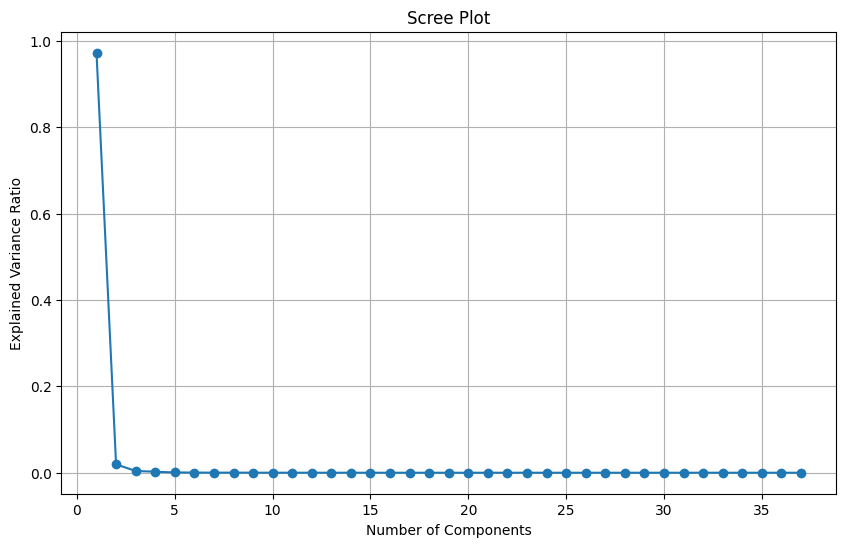

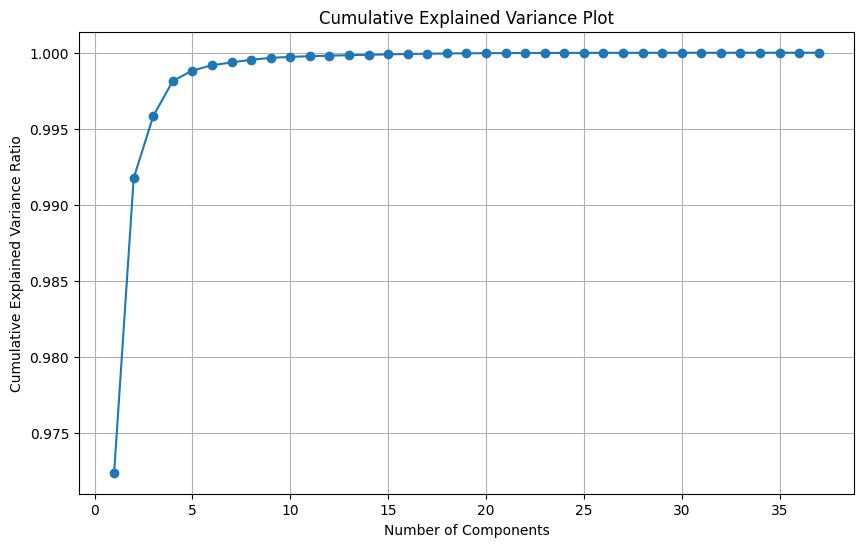

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(tripfinaldf)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

The ideal component number is 5 since it helps us explain the highest variance ration without being prone to noise data.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Models

## Decision Trees

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

X = tripfinaldf.drop(columns=['duration_class'])
y = tripfinaldf['duration_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      4752
           1       0.71      0.70      0.71      9630
           2       0.62      0.64      0.63      5348
           3       0.65      0.66      0.65      2146

    accuracy                           0.68     21876
   macro avg       0.67      0.68      0.68     21876
weighted avg       0.68      0.68      0.68     21876

Accuracy: 0.6840830133479613


We notice that the accuracy is 68%. Since our prediction class is not very balanced, it is also useful to check the f1-scores, which in this case vary between 0.65 and 0.72.

In order to check if the model is overfitting, let us check the training accuracy.

In [ ]:
y_train_pred = model.predict(X_train)

training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.999748580048684


We notice that the testing accuracy is lower than the training by a large amount, indicating a possibility of overfitting.

One way to deal with overfitting is through regularization so let us try that.

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

X = tripfinaldf.drop(columns=['duration_class'])
y = tripfinaldf['duration_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=5, min_samples_leaf=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.70      0.67      4752
           1       0.69      0.66      0.67      9630
           2       0.53      0.58      0.55      5348
           3       0.66      0.55      0.60      2146

    accuracy                           0.64     21876
   macro avg       0.63      0.62      0.63     21876
weighted avg       0.64      0.64      0.64     21876

Accuracy: 0.636039495337356


In [ ]:
y_train_pred = model.predict(X_train)

training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.6375552838188405


Although the overall testing accuracy dropped by a small amount, we can see from the training accuracy that the model does not seem to "memorize" the training data anymore

Let us perform hyperparameter tuning to decide on these values

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

param_grid = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.7202870725909672
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4752
           1       0.75      0.76      0.75      9630
           2       0.69      0.63      0.66      5348
           3       0.63      0.66      0.64      2146

    accuracy                           0.72     21876
   macro avg       0.70      0.71      0.70     21876
weighted avg       0.72      0.72      0.72     21876



In [ ]:
y_pred = best_model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.7325005999794293


Next, we will try training the model on the reduced data using PCA

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_pca, y_train)

y_pred_pca = model.predict(X_test_pca)
print("Classification Report:")
print(classification_report(y_test, y_pred_pca))

accuracy = accuracy_score(y_test, y_pred_pca)
print("Accuracy:", accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      4752
           1       0.67      0.66      0.66      9630
           2       0.55      0.55      0.55      5348
           3       0.42      0.44      0.43      2146

    accuracy                           0.61     21876
   macro avg       0.57      0.58      0.57     21876
weighted avg       0.61      0.61      0.61     21876

Accuracy: 0.6098006948253795


We notice that the model trained on the PCA data resulted in a lower testing accuracy. This might be because we lost information by working on a small amount of components.

## KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  accuracy_score

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn))

accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.45      0.56      0.50      4752
           1       0.57      0.68      0.62      9630
           2       0.45      0.31      0.37      5348
           3       0.42      0.16      0.23      2146

    accuracy                           0.51     21876
   macro avg       0.47      0.43      0.43     21876
weighted avg       0.50      0.51      0.49     21876

Accuracy: 0.5127537026878771


In [ ]:
y_pred_knn = knn_model.predict(X_train)
print("Classification Report (KNN):")
print(classification_report(y_train, y_pred_knn))

accuracy = accuracy_score(y_train, y_pred_knn)
print("Training Accuracy:", accuracy)

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.59      0.73      0.65     18923
           1       0.67      0.79      0.73     38436
           2       0.66      0.46      0.55     21613
           3       0.66      0.28      0.39      8531

    accuracy                           0.65     87503
   macro avg       0.65      0.57      0.58     87503
weighted avg       0.65      0.65      0.63     87503

Training Accuracy: 0.6486063334971373


We notice that our model is overfitting a bit so we will decide on a better k value using hyperparameter tuning

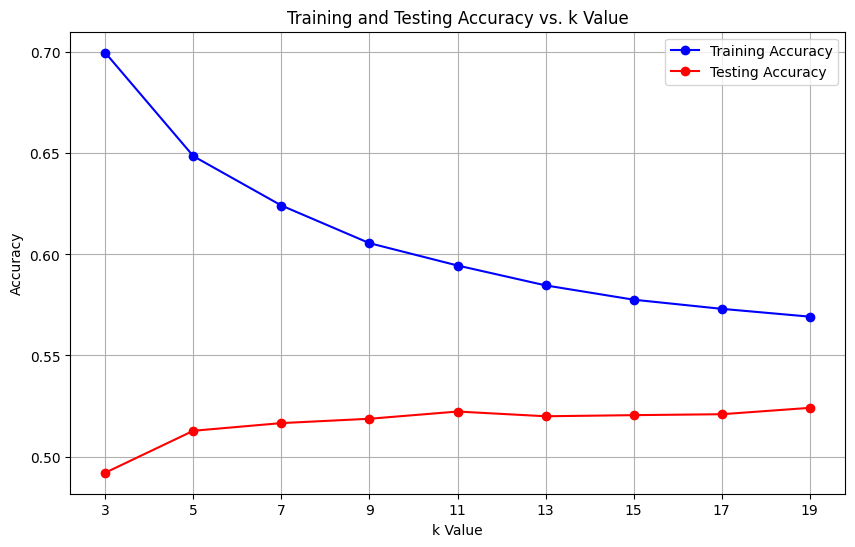

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

k_values = [3, 5, 7, 9, 11, 13, 15, 17, 19]

train_scores = []
test_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    train_score = knn_model.score(X_train, y_train)
    train_scores.append(train_score)

    test_score = knn_model.score(X_test, y_test)
    test_scores.append(test_score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, marker='o', label='Training Accuracy', color='b')
plt.plot(k_values, test_scores, marker='o', label='Testing Accuracy', color='r')
plt.title('Training and Testing Accuracy vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

We can notice that the test accuracy stops improving much after k=11. Hence, we choose this value as the best k value to train our model on

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print("Classification Report (KNN):")
print(classification_report(y_test, y_pred_knn))

accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.48      0.56      0.51      4752
           1       0.56      0.71      0.63      9630
           2       0.46      0.30      0.36      5348
           3       0.44      0.14      0.22      2146

    accuracy                           0.52     21876
   macro avg       0.49      0.43      0.43     21876
weighted avg       0.51      0.52      0.50     21876

Accuracy: 0.5222618394587676


In [ ]:
y_pred_knn = knn_model.predict(X_train)
print("Classification Report (KNN):")
print(classification_report(y_train, y_pred_knn))

accuracy = accuracy_score(y_train, y_pred_knn)
print("Training Accuracy:", accuracy)

Classification Report (KNN):
              precision    recall  f1-score   support

           0       0.55      0.65      0.59     18923
           1       0.62      0.77      0.69     38436
           2       0.59      0.38      0.46     21613
           3       0.57      0.21      0.31      8531

    accuracy                           0.59     87503
   macro avg       0.58      0.50      0.51     87503
weighted avg       0.59      0.59      0.57     87503

Training Accuracy: 0.5945053312457859


With this optimal k value, we have improved the testing accuracy and we also reduced overfitting, since the training accuracy is now close to the testing.

## Random Forest Classifier

Next, we will try the random forest classifier. Random Forests are good models to try since we can aggregate the outcome of multiple predictors.

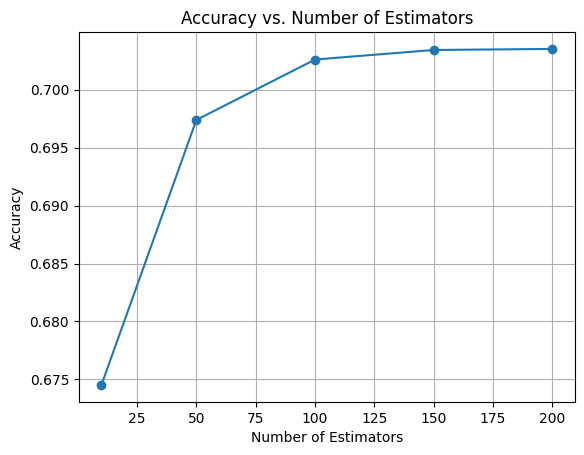

In [ ]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_values = [10, 50, 100, 150, 200]

accuracies = []

for n_estimators in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    rf_model.fit(X_train, y_train)

    y_pred_rf = rf_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_rf)
    accuracies.append(accuracy)

plt.plot(n_estimators_values, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Estimators')
plt.grid(True)
plt.show()


As we can observe from the graph, the optimal number of estimators is 100 so we will train a model using this parameter value

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      4752
           1       0.69      0.78      0.73      9630
           2       0.67      0.57      0.61      5348
           3       0.71      0.72      0.71      2146

    accuracy                           0.70     21876
   macro avg       0.71      0.69      0.70     21876
weighted avg       0.70      0.70      0.70     21876

Accuracy: 0.7025964527335893


The random forest classifier gave us an accuracy of around 70% indicating that it is a good model to be used for our research question.

## Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

nb_model = GaussianNB()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Classification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

accuracy = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy)

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.52      0.21      0.30      4752
           1       0.55      0.75      0.63      9630
           2       0.38      0.32      0.35      5348
           3       0.36      0.38      0.37      2146

    accuracy                           0.49     21876
   macro avg       0.45      0.41      0.41     21876
weighted avg       0.48      0.49      0.46     21876

Accuracy: 0.4914061071493875


The Naive Bayes classifier gave us the lowest test scores. This might be because this model assumes that our features are independent, which is probably not the case for us since we have features like min_temperature and max_temparature that are more likely to be dependent.

## Clustering K-Means

Let us now try with clustering. We go with K-Means.

In [ ]:
from sklearn.cluster import KMeans
k_range = range(1, 10)
features = tripfinaldf.drop(columns=['duration_class'])
wcss_values = []

def calculate_wcss(data, k):
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  kmeans.fit(data)
  return kmeans.inertia_ # wihtin cluster sum of squares

for k in k_range:
  wcss = calculate_wcss(features, k)
  wcss_values.append(wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In order to determine the best k value to use we will use the elbow method. This method consists of comparing the values of 'within cluster sum of squares' that we get at every k.

Of course, the higher k the lesser WCSS, so the elbow method determine the k that achieves the lowest WCSS before adding more k's achieve smaller improvements.

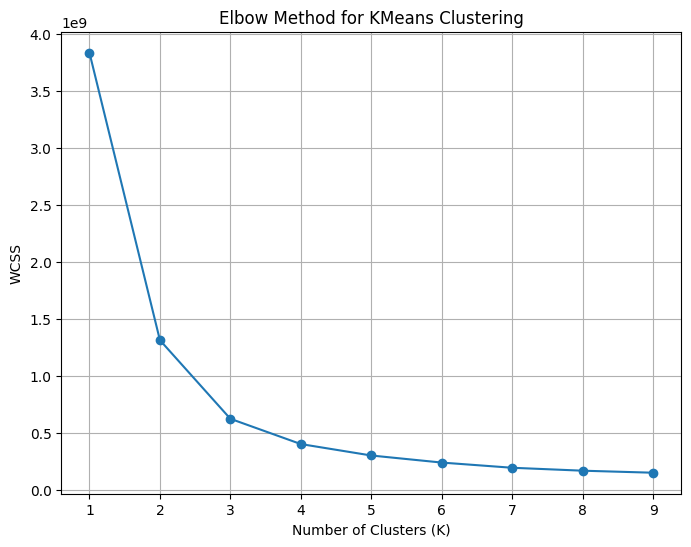

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)

plt.show()

We notice that the value of k = 3 is seen to be the ideal number of clusters. Since beyond k, we do not achieve a much bigger decrease in WCSS.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


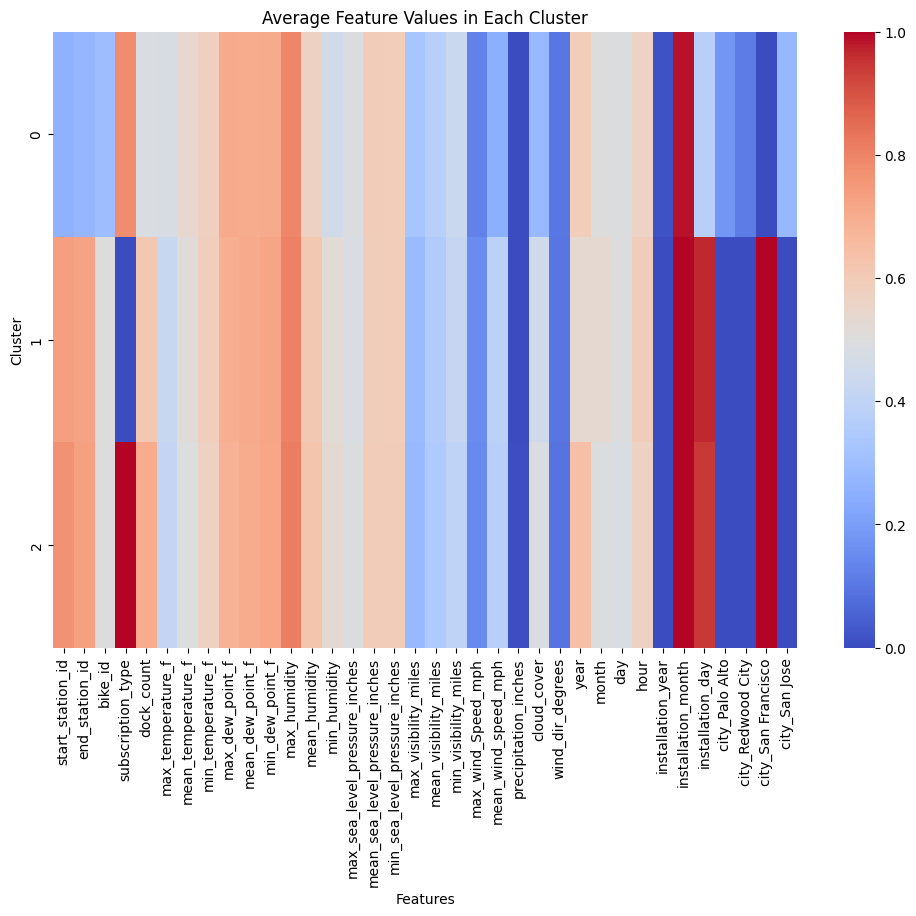

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
cluster_labels = kmeans.fit_predict(scaled_features)

cluster_df = pd.DataFrame({'Cluster': cluster_labels})

scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

clustered_df = pd.concat([scaled_features_df, cluster_df], axis=1)

cluster_means = clustered_df.groupby('Cluster').mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=False, cmap='coolwarm')
plt.title('Average Feature Values in Each Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()

After running our clustering method with k=3, we find the above 3 clusters. In order to better understand what are the unique feature values that these clusters have, we plot the heat map.

The heat map shows that the unique value that differentiates the clusters is the subscription_type.

# ***Research Question 2***


***How accurately can we predict the number of trips on a specific day and within a certain station?***

To go about this research question, we will proceed similarly. This time however, we will be joining dataframes on the weather dataset.

# Data Joining

Let us first proceed to count the number of trips we have based on the day and zip code (number of trips per day and location).

In [ ]:
tripsgroupeddf = tripjoineddf.groupby(['start_day', 'zip_code']).size().reset_index(name='trip_count')
tripsgroupeddf

,start_day,zip_code,trip_count
0,2013-08-29,90103,21
1,2013-08-29,94017,52
2,2013-08-29,94036,5
3,2013-08-29,94041,9
4,2013-08-29,94043,2
...,...,...,...
15824,2015-08-31,94603,2
15825,2015-08-31,95110,14
15826,2015-08-31,95112,6
15827,2015-08-31,95113,4


Now that we have the count of trips ready, per day and location, we join this with our weather dataset, also based on day and location.

In [ ]:
weatherjoineddf = pd.merge(left=weatherdf, right=tripsgroupeddf, left_on=['zip_code', 'date'], right_on=['zip_code', 'start_day'])
weatherjoineddf

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code,start_day,trip_count
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,0.0,4.0,286.0,94107,2013-08-29,94
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,0.0,2.0,291.0,94107,2013-08-30,73
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,0.0,4.0,284.0,94107,2013-08-31,71
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,0.0,4.0,284.0,94107,2013-09-01,60
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,0.0,6.0,277.0,94107,2013-09-02,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,2015-08-27,92.0,78.0,63.0,57.0,51.0,40.0,78.0,48.0,18.0,...,10.0,10.0,23.0,6.0,0.0,3.0,313.0,95113,2015-08-27,6
3471,2015-08-28,95.0,80.0,64.0,64.0,56.0,52.0,93.0,60.0,26.0,...,10.0,10.0,25.0,7.0,0.0,3.0,307.0,95113,2015-08-28,9
3472,2015-08-29,80.0,72.0,64.0,65.0,62.0,54.0,93.0,70.0,47.0,...,10.0,10.0,21.0,9.0,0.0,4.0,312.0,95113,2015-08-29,4
3473,2015-08-30,78.0,70.0,62.0,60.0,57.0,53.0,84.0,64.0,43.0,...,10.0,10.0,22.0,10.0,0.0,3.0,291.0,95113,2015-08-30,5


Now that we have a number of trips per day and zip code, let's go about dropping unecessary columns.

In [ ]:
weatherjoineddf = weatherjoineddf.drop(['start_day'], axis=1)
weatherjoineddf.columns

Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees', 'zip_code', 'trip_count'],
      dtype='object')

# Data Preprocessing

We proceed similarly to what was done above, we first look at our data columns and data types, then proceed accordingly.

In [ ]:
print(weatherjoineddf.columns)
print(weatherjoineddf.dtypes)

Index(['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees', 'zip_code', 'trip_count'],
      dtype='object')
date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float6

In [ ]:
format_str = '%Y-%m-%d'
weatherjoineddf['year'] = pd.to_datetime(weatherjoineddf['date'], format=format_str).dt.year
weatherjoineddf['month'] = pd.to_datetime(weatherjoineddf['date'], format=format_str).dt.month
weatherjoineddf['day'] = pd.to_datetime(weatherjoineddf['date'], format=format_str).dt.day
weatherjoineddf = weatherjoineddf.drop(['date'], axis=1)
print(weatherjoineddf.columns)
print(weatherjoineddf.dtypes)

Index(['max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees', 'zip_code', 'trip_count', 'year', 'month', 'day'],
      dtype='object')
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mea

Now that our data is ready and complete, let's go about visualizing our target variable 'trip_count'.

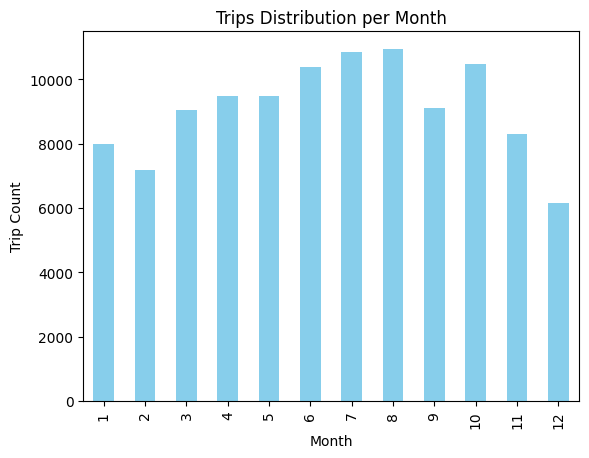

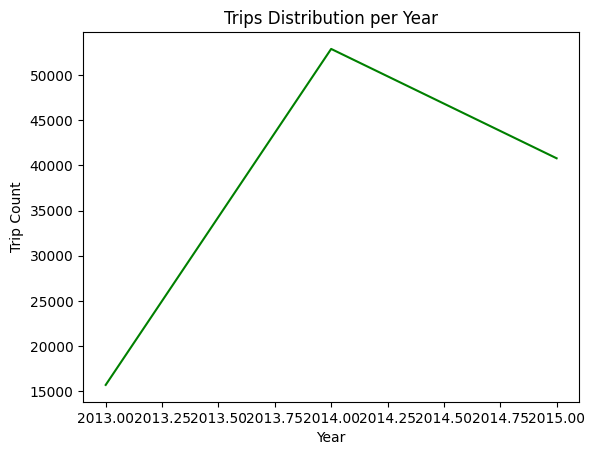

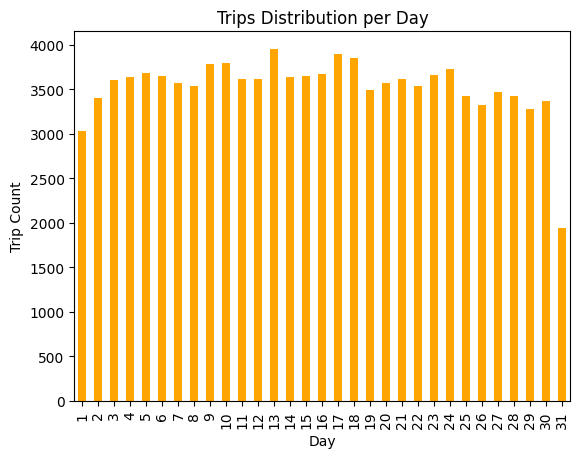

In [ ]:
df_by_month = weatherjoineddf.groupby('month')['trip_count'].sum()
df_by_month.plot(kind='bar', color='skyblue', title='Trips Distribution per Month')
plt.xlabel('Month')
plt.ylabel('Trip Count')
plt.show()

df_by_year =weatherjoineddf.groupby('year')['trip_count'].sum()
df_by_year.plot(kind='line', color='green', title='Trips Distribution per Year')
plt.xlabel('Year')
plt.ylabel('Trip Count')
plt.show()

df_by_day = weatherjoineddf.groupby('day')['trip_count'].sum()
df_by_day.plot(kind='bar', color='orange', title='Trips Distribution per Day')
plt.xlabel('Day')
plt.ylabel('Trip Count')
plt.show()

The graph show us the same insights we got from visualizing our trips dataset, which is a good indication that our work is consitent.

Now, we proceed to selecting variables.
Let's do a correlation matrix, and plot it as a heat map.

In [ ]:
features = weatherjoineddf[weatherjoineddf.columns.tolist()]
correlation_matrix = features.corr()

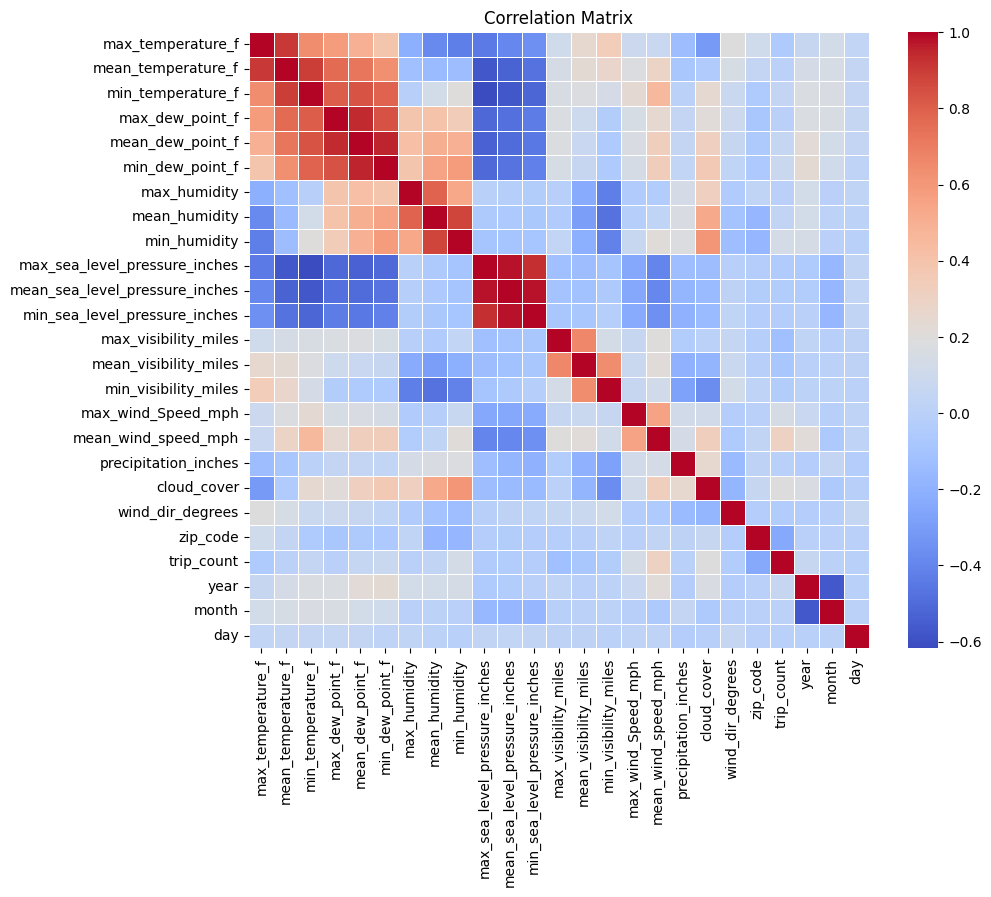

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Notice how our correlation matrix gives us interesting insights:


*   Unsurprinsgly, there are groups that are highly correlated to each other, like min , max and mean temperature, or temperature and humidity, or humidity and cloud cover. This makes sense because these values have a logical natural correlation.

*   Notice how we have a mid-high correlation between trip count and zip code.


*   Also notice how we have a mid-high correlation between wind speed and trip counts.

Let us try the p-values and significant test, and see if our results are conclusive.

In [ ]:
from scipy.stats import pearsonr
features = weatherjoineddf.drop(columns=['trip_count'])  # Extracting features
target = weatherjoineddf['trip_count']

feature_names = []
p_values = []
for column in features.columns:
    correlation, p_value = pearsonr(features[column], target)
    feature_names.append(column)
    p_values.append(p_value)


p_values_df = pd.DataFrame({'Feature': feature_names, 'P-Value': p_values})
print(p_values_df.sort_values(by='P-Value'))

                           Feature       P-Value
16             mean_wind_speed_mph  5.180528e-77
20                        zip_code  3.184949e-48
18                     cloud_cover  1.987891e-31
15              max_wind_Speed_mph  5.252128e-17
8                     min_humidity  1.768281e-14
12            max_visibility_miles  3.971268e-13
5                  min_dew_point_f  2.360923e-06
13           mean_visibility_miles  8.480814e-06
21                            year  2.115285e-04
0                max_temperature_f  1.318515e-03
4                 mean_dew_point_f  1.533120e-03
2                min_temperature_f  2.073342e-03
9    max_sea_level_pressure_inches  9.459849e-03
10  mean_sea_level_pressure_inches  1.650468e-02
19                wind_dir_degrees  1.902597e-02
7                    mean_humidity  2.125791e-02
14            min_visibility_miles  3.926958e-02
11   min_sea_level_pressure_inches  1.003890e-01
23                             day  6.998872e-01
17            precip

Notice how we have 7 values with low p- values (<0.05), let's drop these values

In [ ]:
weatherjoineddf.drop(columns=['max_humidity','max_dew_point_f','mean_temperature_f','month','precipitation_inches','day','min_sea_level_pressure_inches'])

,max_temperature_f,min_temperature_f,mean_dew_point_f,min_dew_point_f,mean_humidity,min_humidity,max_sea_level_pressure_inches,mean_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,wind_dir_degrees,zip_code,trip_count,year
0,74.0,61.0,58.0,56.0,75.0,57.0,30.07,30.02,10.0,10.0,10.0,23.0,11.0,4.0,286.0,94107,94,2013
1,78.0,60.0,58.0,56.0,70.0,50.0,30.05,30.00,10.0,10.0,7.0,29.0,13.0,2.0,291.0,94107,73,2013
2,71.0,57.0,56.0,54.0,75.0,57.0,30.00,29.96,10.0,10.0,10.0,26.0,15.0,4.0,284.0,94107,71,2013
3,74.0,58.0,56.0,53.0,68.0,49.0,29.96,29.93,10.0,10.0,10.0,25.0,13.0,4.0,284.0,94107,60,2013
4,75.0,62.0,60.0,58.0,77.0,61.0,29.97,29.94,10.0,10.0,6.0,23.0,12.0,6.0,277.0,94107,79,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,92.0,63.0,51.0,40.0,48.0,18.0,30.05,30.01,10.0,10.0,10.0,23.0,6.0,3.0,313.0,95113,6,2015
3471,95.0,64.0,56.0,52.0,60.0,26.0,29.96,29.89,10.0,10.0,10.0,25.0,7.0,3.0,307.0,95113,9,2015
3472,80.0,64.0,62.0,54.0,70.0,47.0,30.01,29.96,10.0,10.0,10.0,21.0,9.0,4.0,312.0,95113,4,2015
3473,78.0,62.0,57.0,53.0,64.0,43.0,30.06,30.01,10.0,10.0,10.0,22.0,10.0,3.0,291.0,95113,5,2015


That being done, all we have left is standardization using z-score.

In [ ]:
float_columns = weatherjoineddf.select_dtypes(include=['float']).columns.tolist()
for col in float_columns:
  weatherjoineddf[col] = (weatherjoineddf[col] - weatherjoineddf[col].mean()) / weatherjoineddf[col].std()
print(float_columns)
weatherjoineddf.describe()

['max_temperature_f', 'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity', 'min_humidity', 'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches', 'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph', 'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover', 'wind_dir_degrees']


,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure_inches,...,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,zip_code,trip_count,year,month,day
count,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,...,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3.475000e+03,3475.000000,3475.000000,3475.000000,3475.000000,3475.000000
mean,2.208305e-16,-3.435142e-16,-3.516931e-16,4.089455e-16,-4.253033e-16,-1.308625e-16,-4.580189e-16,3.925876e-16,1.635782e-16,1.041175e-14,...,-1.267731e-16,1.635782e-17,5.520764e-17,4.907346e-17,-9.814691e-17,94331.885180,31.475971,2014.160288,6.479424,15.794820
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,411.097336,49.800635,0.697004,3.400416,8.815592
min,-2.985870e+00,-3.268989e+00,-3.645098e+00,-4.854461e+00,-4.613185e+00,-4.559470e+00,-6.686535e+00,-4.000852e+00,-2.972000e+00,-4.298748e+00,...,-2.129157e+00,-1.810132e+00,-1.424980e-01,-1.224393e+00,-2.657713e+00,94041.000000,1.000000,2013.000000,1.000000,1.000000
25%,-6.928538e-01,-7.613209e-01,-6.762839e-01,-6.136040e-01,-4.986637e-01,-5.818481e-01,-3.706786e-01,-4.799892e-01,-6.641653e-01,-7.032010e-01,...,-4.542538e-01,-9.032389e-01,-1.424980e-01,-7.815112e-01,-1.059444e-01,94063.000000,5.000000,2014.000000,4.000000,8.000000
50%,3.125656e-02,-6.474635e-02,1.333928e-01,1.175783e-01,1.565146e-02,1.706750e-01,6.489774e-02,7.593653e-02,1.051129e-01,-1.039432e-01,...,-6.773766e-02,3.653668e-03,-1.424980e-01,1.042525e-01,2.797880e-01,94107.000000,10.000000,2014.000000,7.000000,16.000000
75%,7.553669e-01,7.711431e-01,8.081234e-01,7.025242e-01,7.871242e-01,8.156949e-01,8.271563e-01,6.318623e-01,6.645879e-01,7.200362e-01,...,4.476173e-01,6.082487e-01,-1.424980e-01,9.900162e-01,6.061770e-01,94301.000000,24.000000,2015.000000,9.000000,23.000000
max,3.772493e+00,3.139496e+00,2.832315e+00,2.164889e+00,2.072912e+00,1.998231e+00,1.589415e+00,2.670257e+00,3.252160e+00,4.315583e+00,...,1.436220e+01,4.840414e+00,2.327821e+01,2.318662e+00,2.475896e+01,95113.000000,233.000000,2015.000000,12.000000,31.000000


# Models



## **Linear Regression**

Let's start with linear regression as a base model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = weatherjoineddf.drop(columns=['trip_count'])
y = weatherjoineddf['trip_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

r2 = r2_score(y_test, y_pred_test)

print("Mean Squared Error (Training):", mse_train)
print("Mean Squared Error (Testing):", mse_test)
print("R Square: %", r2*100)


Mean Squared Error (Training): 1692.838062315764
Mean Squared Error (Testing): 1778.2076320296987
R Square: % 28.789939185485515


Our linear regression model has a coefficient of determination to be 28%. This means that 28% of the variability in trip counts is explained by our features.


Also note how the MSE for both training and testing is similar, we aren't in a case of overfitting.

The poor fit of the model may be explained by the non linear nature of the relationship between our features and our target variable. We can explore other non linear models for this.

## **Decision Tree Regressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

X = weatherjoineddf.drop(columns=['trip_count'])
y = weatherjoineddf['trip_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

r2 = r2_score(y_test, y_pred_test)

X = tripfinaldf.drop(columns=['duration_class'])
y = tripfinaldf['duration_class']

print("Mean Squared Error (Training):", mse_train)
print("Mean Squared Error (Testing):", mse_test)
print("R^2 Score:", r2)


Mean Squared Error (Training): 0.0
Mean Squared Error (Testing): 1184.2748201438849
R^2 Score: 0.5257455853606652


In [ ]:
from sklearn.tree import DecisionTreeRegressor

X = weatherjoineddf.drop(columns=['trip_count'])
y = weatherjoineddf['trip_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("Mean Squared Error (Training):", mse_train)
print("Mean Squared Error (Testing):", mse_test)
print("R^2 Score:", r2)


Mean Squared Error (Training): 0.0
Mean Squared Error (Testing): 1184.2748201438849
R^2 Score: 0.5257455853606652


Notice how our R2 increased to 52.5%. However, the MSE suggests that our model is overfitting the data. Let's look at a non-linear model, maybe it will be more descriptive of the nature of the relationship between our dependant and independant variables.

## KNN

Let's run KNN for the default value K=5.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor()

knn.fit(X_train, y_train)

y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
print("Training Mean Squared Error:", train_mse)
train_r2 = r2_score(y_train, y_pred_train)

print("Training R-squared:", train_r2)

print("Testing Mean Squared Error:", test_mse)
y_variance = y.var()
test_r2 = r2_score(y_test, y_pred_test)

print("Testing R-squared:", test_r2)

Training Mean Squared Error: 451.5554676258993
Training R-squared: 0.8175498702466156
Testing Mean Squared Error: 720.8705611510791
Testing R-squared: 0.7113203454178844


From our KNN model, we get interesting results. Notice how our R2 increased from 50% to 70%, and our test MSE decreased, this confirms our hypothesis that our previous models were not complex enough.

Thus, we decide to go for the KNN model, however let’s try to hyperparameter tune the k and see if we can further improve our accuracy. We train the model on different k’s and compare results by graphing the evolution of R2’s and MSE’s against the ks. We do this for values of K ranging from [1, 10] since these are the common values to be used.


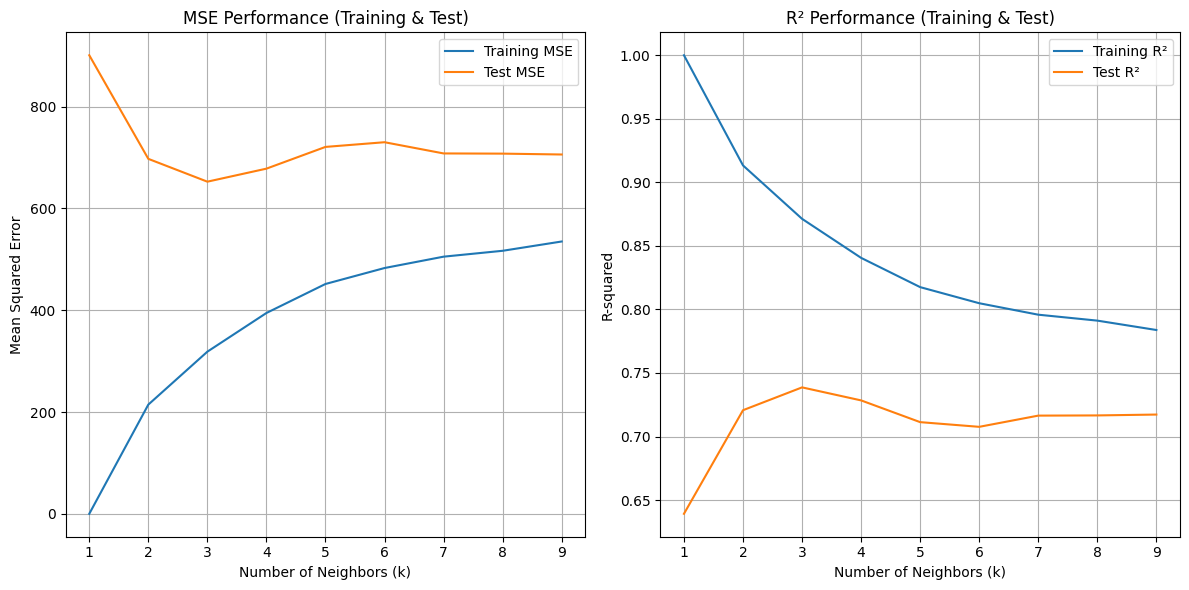

In [ ]:
X = weatherjoineddf.drop(columns=['trip_count'])
y = weatherjoineddf['trip_count']
k_values = range(1, 10)
train_mse_scores = []
test_mse_scores = []
train_r2_scores = []
test_r2_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)

    knn.fit(X_train, y_train)

    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)

    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mse_scores.append(train_mse)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mse_scores.append(test_mse)

    train_r2 = r2_score(y_train, y_pred_train)
    train_r2_scores.append(train_r2)
    test_r2 = r2_score(y_test, y_pred_test)
    test_r2_scores.append(test_r2)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(k_values, train_mse_scores, label='Training MSE')
plt.plot(k_values, test_mse_scores, label='Test MSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.title('MSE Performance (Training & Test)')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(k_values, train_r2_scores, label='Training R²')
plt.plot(k_values, test_r2_scores, label='Test R²')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('R-squared')
plt.title('R² Performance (Training & Test)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Looking at k=1, we see clearly that we have a training MSE of 0 and test MSE very high, this is because k=1 only checks the one closest neighbor, thus it unsurprinsgly overfits the data.


Our best K would be the K that would result in the minimum test MSE.


Notice how k=3 gets us the best R2 value (near 74% ), with the lowest MSE. Thus, it is this model that would be used to answer our research question and predict count of trips on hypothetical data.


# Recommendations

As a conclusion to our work, we deem that we have answered both our research questions by providing multiple models that provide average accuracy.

One way that our results can be improved is by exploring new features outside of the ones present in this dataset. Since our current variables where not enough to produce satisfying results, our next steps as a company would be to do more research on our problematic and collect new data with new features that might be more indicative to our research question.


# Export to pdf


The below code was used to export our report to pdf for submission.


In [ ]:
!pip install nbconvert

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6
  libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fo

In [ ]:
!jupyter nbconvert --to pdf --output Machine_Learning_Project.pdf '/content/drive/MyDrive/Colab Notebooks/Bike Sharing Analysis and Prediction.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Bike Sharing Analysis and Prediction.ipynb to pdf
[NbConvertApp] Support files will be in Machine_Learning_Project_files/
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making directory ./Machine_Learning_Project_files
[NbConvertApp] Making di